# CPE Outcome Regressions
Created: 04/08/24 \
Updated: 05/16/2024


In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM
from joblib import Parallel, delayed
import pickle

import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'
save_dir = f'{base_dir}ephys_analysis/results/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)

05152024


In [6]:
# Subj list for CCN 2024
subj_ids = list(pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
subj_ids


['MS002',
 'MS003',
 'MS004',
 'MS009',
 'MS011',
 'MS015',
 'MS016',
 'MS017',
 'MS019',
 'MS022',
 'MS024',
 'MS025',
 'MS026',
 'MS027',
 'MS028',
 'MS029',
 'MS030',
 'MS033',
 'MS035',
 'MS041',
 'MS043']

# Load data
- First run - load all power_epochs data, after just save as pickle dict
- Get subj metadata for regression dfs + compute logRT & logRT_t1

In [72]:
analysis_freqs = {'hfa':[70,200],'beta':[13,30]}
analysis_freqs
# example from coh script
# freq_bands = {"delta": [2.0, 4.0],"theta": [4.0, 8.0], "alpha": [8.0, 13.0], "low_beta": [13.0, 20.0],
#               "high_beta":[20.0, 30.0],"low_gamma":[30.0, 40.0]}

{'hfa': [70, 200], 'beta': [13, 30]}

In [9]:
# all_subj_power = {}
# all_subj_metadata  = {}


# # load pow epochs data 
# for subj_id in subj_ids: 
    
#     # load cpe power epochs for single subject 
#     power_epochs = mne.time_frequency.read_tfrs(f'{neural_dir}{subj_id}/{subj_id}_CpeOnset-tfr.h5')[0]
#     # save epochs metatdata with noise/IED info and behav regressors (NOT ZSCORED)
#     power_metadata = power_epochs.metadata
#     all_subj_metadata[subj_id] = power_metadata
#     # convert mne power data to data frame
#     power_df = power_epochs.to_data_frame()
#     del power_epochs # remove power epochs from memory to speed up loop
#     subj_band_dfs = {}
#     # extract power df with mean freq-specific power for each epoch for each elec 
#     for band,freq_range in analysis_freqs.items():
#         band_df = power_df[(power_df.freq >= freq_range[0])&(power_df.freq <= freq_range[1])].groupby(['epoch']).agg('mean').reset_index()
#         band_df['band'] = band
#         subj_band_dfs[band] = band_df 
#     del power_df # delete full power df to save memory
#     all_subj_power[subj_id] = subj_band_dfs
    
# # # create a binary pickle file 
# pickle.dump(all_subj_power,
#             open(f'{save_dir}all_subj_power_{("_").join(list(analysis_freqs.keys()))}_{date}.pkl',"wb"))

# # # create a binary pickle file 
# pickle.dump(all_subj_metadata,
#             open(f'{save_dir}all_subj_metadata_{date}.pkl',"wb")) 

In [11]:
all_subj_power = pickle.load(open(f'{save_dir}all_subj_power_{("_").join(list(analysis_freqs.keys()))}_0{load_date}.pkl','rb'))
all_subj_power


{'MS002': {'hfa':      epoch  time        freq  lacas1-lacas2  lacas2-lacas3  lacas3-lacas4  \
  0        0   1.5  118.986976      -0.015546      -0.054236      -0.020566   
  1        1   1.5  118.986976      -0.003153      -0.006854       0.002026   
  2        2   1.5  118.986976       0.111682       0.106656      -0.009276   
  3        3   1.5  118.986976       0.108610       0.050576       0.135765   
  4        4   1.5  118.986976       0.097291       0.080731      -0.066827   
  ..     ...   ...         ...            ...            ...            ...   
  144    144   1.5  118.986976       0.011243      -0.000056       0.014588   
  145    145   1.5  118.986976      -0.005321       0.070241      -0.064144   
  146    146   1.5  118.986976       0.036919       0.023276       0.047410   
  147    147   1.5  118.986976      -0.044906      -0.016485       0.030436   
  148    148   1.5  118.986976      -0.084958      -0.117649      -0.024605   
  
       lacas4-lacas5  lacas5-laca

In [10]:
# load newest file
metadata_paths = glob(f'{save_dir}all_subj_metadata_*.pkl')
load_date = str(np.max([int(path.split('_')[-1][:-4]) # find most recent saved df to load 
                        for path in metadata_paths]))

all_subj_metadata = pickle.load(open(f'{save_dir}all_subj_metadata_0{load_date}.pkl','rb'))

In [12]:
### zscore continuous metadata regressors (already done - how???)

continuous_regressors = ['SafeBet','LowBet', 'HighBet', 'GambleEV','Profit', 'TotalProfit',
                         'CR', 'choiceEV', 'RPE', 'decisionCPE', 'decisionRegret',
                         'decisionRelief', 'decisionCF']


for subj_id,metadata in zip(all_subj_metadata.keys(),all_subj_metadata.values()):
    for reg in continuous_regressors:
        metadata[reg] = zscore(metadata[reg])
    all_subj_metadata[subj_id] = metadata

In [13]:
for subj_id,metadata in zip(all_subj_metadata.keys(),all_subj_metadata.values()):
    logRT_list        = np.log(metadata['RT']).tolist() # take log of RT
    metadata['logRT'] = logRT_list # add logRT to metadata
    logRT_t1_list     = logRT_list[1:] # get logRT_t1
    logRT_t1_list.append(np.nan) # add nan to logRT_t1 (no t1 for last round)
    metadata['logRT_t1']       = logRT_t1_list
    all_subj_metadata[subj_id] = metadata
    

# Create Freq-Specific Regression Dataframes 
- Currently focused on HFA and beta

In [16]:
#### add roi info to master df 
roi_reref_labels_master_df = pd.read_csv(glob(f'{base_dir}ephys_analysis/subj_info/roi_reref_labels_master_0{load_date}.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])

regression_band_data = {'hfa':[],'beta':[]}

# hard coded bc same for all subj
metadata_id_vars = ['epoch','Round','logRT','logRT_t1','TrialType', 'SafeBet', 'LowBet', 'HighBet',
                    'GambleChoice','Outcome', 'Profit', 'TotalProfit','GambleEV', 'CR', 'choiceEV', 
                    'RPE','decisionCPE', 'decisionRegret','decisionRelief','decisionCF']


for subj_id,subj_pow_dict in zip(all_subj_power.keys(),all_subj_power.values()):
    
#     freq_bands = subj_pow_dicts.keys()
    
    for band,pow_df in zip(subj_pow_dict.keys(),subj_pow_dict.values()):
#         print(pow_df.columns)
    #     pow_df.to_csv(f'{save_dir}{subj_id}_epochs_hfa_power.csv')
    #     all_subj_metadata[subj_id].to_csv(f'{save_dir}{subj_id}_epochs_hfa_metadata.csv')

        # reshape pow_df 
        pow_reg_df = pow_df.melt(id_vars=['epoch','freq','band'],
                                    value_vars=pow_df.columns.drop(['epoch','time','freq']).tolist().copy(),
                                    var_name='reref_ch_names', value_name='band_pow',
                                    ignore_index = False)

        pow_reg_df['subj_id'] = subj_id # add subj_id to df values
        # reshape metadata df 
        metadata_df = all_subj_metadata[subj_id].reset_index()
        metadata_df = metadata_df.rename(columns={'index':'epoch'})
        value_vars = np.setdiff1d(metadata_df.columns.tolist(),metadata_id_vars).tolist()
#         metadata_reg_df = metadata_df.melt(id_vars=metadata_id_vars,value_vars=value_vars,
#                                            var_name='reref_ch_names', value_name='epoch_info',
#                                           ignore_index = False)

        # merge pow and metadata dfs keeping epoch as index 
        subj_regression_df = pd.merge(pow_reg_df, metadata_df,left_on=['epoch'],
                                    right_on=['epoch']).reset_index(drop=True).set_index('epoch')
        subj_regression_df['epoch_num'] = subj_regression_df.index # keep epoch as a column

        # add roi info 
        subj_epochs = pow_reg_df.epoch.unique()
        # extract roi_reref_labels_df for each subj 
        subj_roi_reref_labels = roi_reref_labels_master_df[roi_reref_labels_master_df['subj_id']==subj_id]
        # add epochs to df - repeat each elec id for every epoch to join with master df 
        subj_roi_reref_labels = roi_reref_labels_master_df[roi_reref_labels_master_df['subj_id']==subj_id]
        subj_roi_reref_labels = (pd.concat([subj_roi_reref_labels]*len(subj_epochs),
                   keys = subj_epochs,
                   names = ['epoch',None])).reset_index(level=1,drop=True) #make sure epochs are the index
        subj_roi_reref_labels['epoch_num'] = subj_roi_reref_labels.index

        # create unique reref ch id for regression
        subj_roi_reref_labels['unique_reref_ch'] = subj_roi_reref_labels[['subj_id', 'reref_ch_names']].agg('_'.join, axis=1)

        # merge regression df with roi reref info df  
        subj_regression_df = pd.merge(subj_regression_df, subj_roi_reref_labels,left_on=['subj_id','reref_ch_names','epoch_num'],
                                    right_on=['subj_id','reref_ch_names','epoch_num']).reset_index(drop=True).set_index('epoch_num')
        
        subj_regression_df['epoch'] = subj_regression_df.index
        
        regression_band_data[band].append(subj_regression_df)

        


regression_band_data


{'hfa': [                 freq band  reref_ch_names  band_pow subj_id Round        RT  \
  epoch_num                                                                      
  0          118.986976  hfa   lacas1-lacas2 -0.015546   MS002     1  2.059852   
  0          118.986976  hfa   lacas2-lacas3 -0.054236   MS002     1  2.059852   
  0          118.986976  hfa   lacas3-lacas4 -0.020566   MS002     1  2.059852   
  0          118.986976  hfa   lacas4-lacas5 -0.062047   MS002     1  2.059852   
  0          118.986976  hfa   lacas5-lacas6 -0.195799   MS002     1  2.059852   
  ...               ...  ...             ...       ...     ...   ...       ...   
  148        118.986976  hfa   rmoif5-rmoif6  0.079808   MS002   150  1.854358   
  148        118.986976  hfa   rmoif6-rmoif7  0.021137   MS002   150  1.854358   
  148        118.986976  hfa   rmoif7-rmoif8  0.046392   MS002   150  1.854358   
  148        118.986976  hfa   rmoif8-rmoif9  0.060803   MS002   150  1.854358   
  148    

### make hfa and beta reg dfs


In [21]:
regression_band_data['hfa'][0].columns

Index(['freq', 'band', 'reref_ch_names', 'band_pow', 'subj_id', 'Round', 'RT',
       'CpeOnset', 'GambleChoice', 'TrialType', 'SafeBet', 'LowBet', 'HighBet',
       'GambleEV', 'Outcome', 'Profit', 'TotalProfit', 'CR', 'choiceEV', 'RPE',
       'decisionCPE', 'decisionRegret', 'decisionRelief', 'decisionCF',
       'logRT', 'logRT_t1', 'ch_label4roi', 'ch_type4roi', 'loc4roi', 'mni_x',
       'mni_y', 'mni_z', 'hemi', 'roi', 'unique_reref_ch', 'epoch'],
      dtype='object')

In [64]:
hfa_master_data = pd.concat(regression_band_data['hfa'])

hfa_master_data = hfa_master_data[['subj_id', 'reref_ch_names', 'unique_reref_ch', 'epoch', 'freq', 'band',
       'band_pow', 'roi', 'hemi', 'ch_label4roi', 'ch_type4roi', 'loc4roi',
       'Round', 'logRT', 'logRT_t1', 'TrialType', 'SafeBet', 'LowBet',
       'HighBet', 'GambleChoice', 'Outcome', 'Profit', 'TotalProfit',
       'GambleEV', 'CR', 'choiceEV', 'RPE', 'decisionCPE', 'decisionRegret',
       'decisionRelief', 'decisionCF']]

# remove fail trials from dataframe
hfa_master_data = hfa_master_data[(hfa_master_data.GambleChoice=='gamble')|(hfa_master_data.GambleChoice=='safe')]
hfa_master_data = hfa_master_data[~hfa_master_data.Outcome.isnull()]
hfa_master_data['GambleChoice'] = hfa_master_data['GambleChoice'].astype('category')
hfa_master_data['TrialType']    = hfa_master_data['TrialType'].astype('category')


hfa_master_data.to_csv(f'{save_dir}hfa_master_data_{date}.csv')
hfa_master_data


,subj_id,reref_ch_names,unique_reref_ch,epoch,freq,band,band_pow,roi,hemi,ch_label4roi,...,Profit,TotalProfit,GambleEV,CR,choiceEV,RPE,decisionCPE,decisionRegret,decisionRelief,decisionCF
epoch_num,,,,,,,,,,,,,,,,,,,,,
0,MS002,lacas1-lacas2,MS002_lacas1-lacas2,0,118.986976,hfa,-0.015546,acc,l,lacas1,...,-0.055891,-1.986819,-0.435135,0.149851,-0.167551,-0.029158,-0.801987,-0.588002,-0.787471,0.762781
0,MS002,lacas2-lacas3,MS002_lacas2-lacas3,0,118.986976,hfa,-0.054236,acc,l,lacas2,...,-0.055891,-1.986819,-0.435135,0.149851,-0.167551,-0.029158,-0.801987,-0.588002,-0.787471,0.762781
0,MS002,lacas3-lacas4,MS002_lacas3-lacas4,0,118.986976,hfa,-0.020566,acc,l,lacas3,...,-0.055891,-1.986819,-0.435135,0.149851,-0.167551,-0.029158,-0.801987,-0.588002,-0.787471,0.762781
0,MS002,lacas4-lacas5,MS002_lacas4-lacas5,0,118.986976,hfa,-0.062047,acc,l,lacas4,...,-0.055891,-1.986819,-0.435135,0.149851,-0.167551,-0.029158,-0.801987,-0.588002,-0.787471,0.762781
0,MS002,lacas5-lacas6,MS002_lacas5-lacas6,0,118.986976,hfa,-0.195799,acc,l,lacas5,...,-0.055891,-1.986819,-0.435135,0.149851,-0.167551,-0.029158,-0.801987,-0.588002,-0.787471,0.762781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,MS043,rmolf2-rmolf3,MS043_rmolf2-rmolf3,149,118.986976,hfa,-0.083862,ofc,r,rmolf2,...,-0.121451,0.575449,1.984711,0.303851,2.607707,-1.966084,-1.006588,-1.180828,-0.739626,1.057748
149,MS043,rmolf5-rmolf6,MS043_rmolf5-rmolf6,149,118.986976,hfa,0.009250,ofc,r,rmolf5,...,-0.121451,0.575449,1.984711,0.303851,2.607707,-1.966084,-1.006588,-1.180828,-0.739626,1.057748
149,MS043,rmolf6-rmolf7,MS043_rmolf6-rmolf7,149,118.986976,hfa,-0.077225,ofc,r,rmolf6,...,-0.121451,0.575449,1.984711,0.303851,2.607707,-1.966084,-1.006588,-1.180828,-0.739626,1.057748


In [63]:
beta_master_data = pd.concat(regression_band_data['beta'])

beta_master_data = beta_master_data[['subj_id', 'reref_ch_names', 'unique_reref_ch', 'epoch', 'freq', 'band',
       'band_pow', 'roi', 'hemi', 'ch_label4roi', 'ch_type4roi', 'loc4roi',
       'Round', 'logRT', 'logRT_t1', 'TrialType', 'SafeBet', 'LowBet',
       'HighBet', 'GambleChoice', 'Outcome', 'Profit', 'TotalProfit',
       'GambleEV', 'CR', 'choiceEV', 'RPE', 'decisionCPE', 'decisionRegret',
       'decisionRelief', 'decisionCF']]

# remove fail trials from dataframe
beta_master_data = beta_master_data[(beta_master_data.GambleChoice=='gamble')|(beta_master_data.GambleChoice=='safe')]
beta_master_data = beta_master_data[~beta_master_data.Outcome.isnull()]
beta_master_data['GambleChoice'] = beta_master_data['GambleChoice'].astype('category')
beta_master_data['TrialType']    = beta_master_data['TrialType'].astype('category')

beta_master_data.to_csv(f'{save_dir}beta_master_data_{date}.csv')
beta_master_data


,subj_id,reref_ch_names,unique_reref_ch,epoch,freq,band,band_pow,roi,hemi,ch_label4roi,...,Profit,TotalProfit,GambleEV,CR,choiceEV,RPE,decisionCPE,decisionRegret,decisionRelief,decisionCF
epoch_num,,,,,,,,,,,,,,,,,,,,,
0,MS002,lacas1-lacas2,MS002_lacas1-lacas2,0,20.743342,beta,-0.123631,acc,l,lacas1,...,-0.055891,-1.986819,-0.435135,0.149851,-0.167551,-0.029158,-0.801987,-0.588002,-0.787471,0.762781
0,MS002,lacas2-lacas3,MS002_lacas2-lacas3,0,20.743342,beta,-0.186515,acc,l,lacas2,...,-0.055891,-1.986819,-0.435135,0.149851,-0.167551,-0.029158,-0.801987,-0.588002,-0.787471,0.762781
0,MS002,lacas3-lacas4,MS002_lacas3-lacas4,0,20.743342,beta,-0.234889,acc,l,lacas3,...,-0.055891,-1.986819,-0.435135,0.149851,-0.167551,-0.029158,-0.801987,-0.588002,-0.787471,0.762781
0,MS002,lacas4-lacas5,MS002_lacas4-lacas5,0,20.743342,beta,-0.085822,acc,l,lacas4,...,-0.055891,-1.986819,-0.435135,0.149851,-0.167551,-0.029158,-0.801987,-0.588002,-0.787471,0.762781
0,MS002,lacas5-lacas6,MS002_lacas5-lacas6,0,20.743342,beta,-0.145367,acc,l,lacas5,...,-0.055891,-1.986819,-0.435135,0.149851,-0.167551,-0.029158,-0.801987,-0.588002,-0.787471,0.762781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,MS043,rmolf2-rmolf3,MS043_rmolf2-rmolf3,149,20.743342,beta,-0.013697,ofc,r,rmolf2,...,-0.121451,0.575449,1.984711,0.303851,2.607707,-1.966084,-1.006588,-1.180828,-0.739626,1.057748
149,MS043,rmolf5-rmolf6,MS043_rmolf5-rmolf6,149,20.743342,beta,0.130135,ofc,r,rmolf5,...,-0.121451,0.575449,1.984711,0.303851,2.607707,-1.966084,-1.006588,-1.180828,-0.739626,1.057748
149,MS043,rmolf6-rmolf7,MS043_rmolf6-rmolf7,149,20.743342,beta,-0.093271,ofc,r,rmolf6,...,-0.121451,0.575449,1.984711,0.303851,2.607707,-1.966084,-1.006588,-1.180828,-0.739626,1.057748


In [45]:
print(hfa_master_data.band_pow.max(),hfa_master_data.band_pow.mean(),hfa_master_data.band_pow.std(),hfa_master_data.band_pow.min())


4.040370763715098 -0.022839681518603692 0.1745838645192682 -0.9972962974664711


In [44]:
#### before removing outliers - 
print(beta_master_data.band_pow.max(),beta_master_data.band_pow.mean(),beta_master_data.band_pow.std(),beta_master_data.band_pow.min())
#https://solomonkurz.netlify.app/blog/2019-02-02-robust-linear-regression-with-student-s-t-distribution/


6.032424943209175 -0.06437617066889628 0.24074509324657278 -0.9803847735293695


# HFA CPE Regression


In [79]:
hfa_reg_df= hfa_master_data.copy()

## Test Regressor Collinearity

In [71]:
### All potential vars of interest 
vif_df = pd.DataFrame({'GambleChoice':pd.factorize(hfa_master_data.GambleChoice)[0],
                       'TrialType':pd.factorize(hfa_master_data.TrialType)[0],
#                        'SafeBet':hfa_master_data.SafeBet,
                       'GambleEV':hfa_master_data.GambleEV,
#                        'Profit':hfa_master_data.Profit,
                       'TotalProfit':hfa_master_data.TotalProfit,
                       'RPE':hfa_master_data.RPE,
                       'decisionCPE':hfa_master_data.decisionCPE})


vif_df = vif_df.astype(float)


vif_data = pd.DataFrame() 
vif_data["feature"] = vif_df.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(vif_df.values, i) 
                          for i in range(len(vif_df.columns))] 

  
print(vif_data)

        feature       VIF
0  GambleChoice  1.765139
1     TrialType  1.874877
2      GambleEV  1.119084
3   TotalProfit  1.016076
4           RPE  1.860926
5   decisionCPE  1.855143


# Simple Models

## Simple regression 

In [46]:
hfa_simple = smf.ols(
    formula='band_pow ~ 1 + decisionCPE',
    data = hfa_master_data,missing='drop')
hfa_simple_fit = hfa_simple.fit()
print(hfa_simple_fit.summary())

                            OLS Regression Results                            
Dep. Variable:               band_pow   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     19.25
Date:                Wed, 15 May 2024   Prob (F-statistic):           1.15e-05
Time:                        19:23:43   Log-Likelihood:                 70630.
No. Observations:              216351   AIC:                        -1.413e+05
Df Residuals:                  216349   BIC:                        -1.412e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0228      0.000    -60.862      

## Mixed effects with just CPE 
random slopes/int for each elec 

In [73]:
cpe_hfa_model = smf.mixedlm(
    formula='band_pow ~ 1 + decisionCPE',
    re_formula = ' decisionCPE',
    data = hfa_master_data,groups=hfa_master_data['unique_reref_ch'], missing='drop')
cpe_hfa_model_fit = cpe_hfa_model.fit()
print(cpe_hfa_model_fit.summary())

              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    band_pow   
No. Observations:    216351     Method:                REML       
No. Groups:          1504       Scale:                 0.0221     
Min. group size:     101        Log-Likelihood:        102431.8710
Max. group size:     150        Converged:             Yes        
Mean group size:     143.9                                        
------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               -0.022    0.002 -9.397 0.000 -0.027 -0.018
decisionCPE              0.002    0.000  5.047 0.000  0.001  0.002
Group Var                0.008    0.002                           
Group x decisionCPE Cov -0.000    0.000                           
decisionCPE Var          0.000    0.000                           



In [202]:
cpe_hfa_model = smf.mixedlm(
    formula='band_pow ~ 1 + C(TrialType)+ decisionCPE',
    re_formula = ' decisionCPE',
    data = hfa_master_data,groups=hfa_master_data['unique_reref_ch'], missing='drop')
cpe_hfa_model_fit = cpe_hfa_model.fit()
print(cpe_hfa_model_fit.summary())

              Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    band_pow   
No. Observations:    216351     Method:                REML       
No. Groups:          1504       Scale:                 0.0221     
Min. group size:     101        Log-Likelihood:        102419.6027
Max. group size:     150        Converged:             Yes        
Mean group size:     143.9                                        
------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept               -0.022    0.002 -9.309 0.000 -0.027 -0.018
C(TrialType)[T.loss]     0.001    0.001  0.709 0.478 -0.001  0.002
C(TrialType)[T.mix]     -0.000    0.001 -0.005 0.996 -0.002  0.002
decisionCPE              0.002    0.000  5.059 0.000  0.001  0.002
Group Var                0.008    0.002                           
Group x de

In [ ]:
cpe_hfa_model = smf.mixedlm(
    formula='band_pow ~ 1 + C(GambleChoice)+ decisionCPE',
    re_formula = ' decisionCPE',
    data = hfa_master_data,groups=hfa_master_data['unique_reref_ch'], missing='drop')
cpe_hfa_model_fit = cpe_hfa_model.fit()
print(cpe_hfa_model_fit.summary())

# Multivariable mixed effects models

## Define model fit functions/params 

In [186]:
def bic(model_fit):
    K = len(model_fit.params)
    n = len(model_fit.resid)
    ll = model_fit.llf
    bic = (K*np.log(n)) - 2*ll
    
    return bic


In [187]:
def run_multi_hfa_model(df, regressor_vars, outcome_var, rand_eff_var):
    # define formula, random effects formula
    formula    = (' + ').join(regressor_vars)
    re_formula = formula
    formula    = f'{outcome_var} ~ 1 + {formula}'
    # run model
    model_fit = smf.mixedlm(
        formula = formula, re_formula = re_formula,
        data = df, groups=df[rand_eff_var], missing='drop').fit()
    
    model_bic = bic(model_fit)
    return model_fit, model_bic

In [77]:
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'

# MODEL SELECTION

## Test Covariates

In [80]:
######### Model 1 
var_list = ['C(GambleChoice)','C(TrialType)','GambleEV','decisionCPE']
model1_fit, model1_bic = run_multi_hfa_model(hfa_reg_df,var_list,outcome_var,rand_eff_var)

In [81]:
######### Model 3
var_list = ['C(GambleChoice)','GambleEV','TotalProfit','decisionCPE']
model3_fit, model3_bic = run_multi_hfa_model(hfa_reg_df,var_list,outcome_var,rand_eff_var)

In [82]:
######### Model 4
var_list = ['C(GambleChoice)','GambleEV','RPE','decisionCPE']
model4_fit, model4_bic = run_multi_hfa_model(hfa_reg_df,var_list,outcome_var,rand_eff_var)

In [83]:
######### Model 2 
var_list = ['C(GambleChoice)','GambleEV','TotalProfit','RPE','decisionCPE']
model2_fit, model2_bic = run_multi_hfa_model(hfa_reg_df,var_list,outcome_var,rand_eff_var)

In [84]:
######### Model 6
var_list = ['C(TrialType)','GambleEV','TotalProfit','decisionCPE']
model6_fit, model6_bic = run_multi_hfa_model(hfa_reg_df,var_list,outcome_var,rand_eff_var)

In [85]:
######### Model 5
var_list = ['C(TrialType)','GambleEV','RPE','decisionCPE']
model5_fit, model5_bic = run_multi_hfa_model(hfa_reg_df,var_list,outcome_var,rand_eff_var)

In [86]:
######### Model 7
var_list = ['C(TrialType)','GambleEV','TotalProfit','RPE','decisionCPE']
model7_fit, model7_bic = run_multi_hfa_model(hfa_reg_df,var_list,outcome_var,rand_eff_var)


In [87]:
gamble_choice2_4 = [model3_bic,model4_bic,model2_bic] #diff order so models align
gamble_choice2_4

[-212767.54442405517, -205303.89893415247, -212851.6472640433]

In [88]:
trial_type5_7 = [model6_bic,model5_bic,model7_bic]
trial_type5_7

[-212085.81380335658, -201878.26465652368, -212227.05640929294]

In [89]:
#### WITH EV MODELS testing trialtype vs gamble choice + total profit vs+/-RPE
list(zip(gamble_choice2_4,trial_type5_7))

[(-212767.54442405517, -212085.81380335658),
 (-205303.89893415247, -201878.26465652368),
 (-212851.6472640433, -212227.05640929294)]

In [90]:
######### Model 8
var_list = ['C(GambleChoice)','TotalProfit','decisionCPE']
model8_fit, model8_bic = run_multi_hfa_model(hfa_reg_df,var_list,outcome_var,rand_eff_var)

In [91]:
######### Model 9
var_list = ['C(GambleChoice)','RPE','decisionCPE']
model9_fit, model9_bic = run_multi_hfa_model(hfa_reg_df,var_list,outcome_var,rand_eff_var)

In [92]:
######### Model 10
var_list = ['C(GambleChoice)','TotalProfit','RPE','decisionCPE']
model10_fit, model10_bic = run_multi_hfa_model(hfa_reg_df,var_list,outcome_var,rand_eff_var)

In [93]:
######### Model 11
var_list = ['C(TrialType)','TotalProfit','decisionCPE']
model11_fit, model11_bic = run_multi_hfa_model(hfa_reg_df,var_list,outcome_var,rand_eff_var)

In [94]:
######### Model 12
var_list = ['C(TrialType)','RPE','decisionCPE']
model12_fit, model12_bic = run_multi_hfa_model(hfa_reg_df,var_list,outcome_var,rand_eff_var)

In [95]:
######### Model 13
var_list = ['C(TrialType)','TotalProfit','RPE','decisionCPE']
model13_fit, model13_bic = run_multi_hfa_model(hfa_reg_df,var_list,outcome_var,rand_eff_var)

In [96]:
gamble_choice8_10 = [model8_bic,model9_bic,model10_bic]
gamble_choice8_10

[-212829.80047160978, -205352.08765471898, -212899.062469407]

In [97]:
trial_type11_13 = [model11_bic,model12_bic,model13_bic]
trial_type11_13

[-212175.66480013265, -203870.36165296801, -212041.60878403622]

In [98]:
#### NO EV MODELS testing trialtype vs gamble choice + total profit vs+/-RPE
list(zip(gamble_choice8_10,trial_type11_13))

[(-212829.80047160978, -212175.66480013265),
 (-205352.08765471898, -203870.36165296801),
 (-212899.062469407, -212041.60878403622)]

In [99]:
######### WITH EV MODELS VS NO EV MODELS - W CHOICE
list(zip(gamble_choice2_4,gamble_choice8_10))

[(-212767.54442405517, -212829.80047160978),
 (-205303.89893415247, -205352.08765471898),
 (-212851.6472640433, -212899.062469407)]

In [100]:
######### WITH EV MODELS VS NO EV MODELS - W TYPE
list(zip(trial_type5_7,trial_type11_13))

[(-212085.81380335658, -212175.66480013265),
 (-201878.26465652368, -203870.36165296801),
 (-212227.05640929294, -212041.60878403622)]

In [101]:
######### Model 14
var_list = ['C(GambleChoice)','GambleEV','decisionCPE']
model14_fit, model14_bic = run_multi_hfa_model(hfa_reg_df,var_list,outcome_var,rand_eff_var)

In [102]:
######### Model 15
var_list = ['C(GambleChoice)','TotalProfit','decisionCPE']
model15_fit, model15_bic = run_multi_hfa_model(hfa_reg_df,var_list,outcome_var,rand_eff_var)

In [103]:
######### Model 16
var_list = ['C(GambleChoice)','RPE','decisionCPE']
model16_fit, model16_bic = run_multi_hfa_model(hfa_reg_df,var_list,outcome_var,rand_eff_var)

In [104]:
######### Model 17
var_list = ['C(GambleChoice)','TotalProfit','RPE','decisionCPE']
model17_fit, model17_bic = run_multi_hfa_model(hfa_reg_df,var_list,outcome_var,rand_eff_var)

In [105]:
######### Model 18
var_list = ['C(TrialType)','GambleEV','decisionCPE']
model18_fit, model18_bic = run_multi_hfa_model(hfa_reg_df,var_list,outcome_var,rand_eff_var)

In [106]:
######### Model 19
var_list = ['C(TrialType)','TotalProfit','decisionCPE']
model19_fit, model19_bic = run_multi_hfa_model(hfa_reg_df,var_list,outcome_var,rand_eff_var)

In [107]:
######### Model 20
var_list = ['C(TrialType)','RPE','decisionCPE']
model20_fit, model20_bic = run_multi_hfa_model(hfa_reg_df,var_list,outcome_var,rand_eff_var)

In [108]:
######### Model 21
var_list = ['C(TrialType)','TotalProfit','RPE','decisionCPE']
model21_fit, model21_bic = run_multi_hfa_model(hfa_reg_df,var_list,outcome_var,rand_eff_var)

In [109]:
gamble_choice14_17 = [model14_bic,model15_bic,model16_bic,model17_bic] #diff order so models align
gamble_choice14_17

[-205235.24540491434,
 -212829.80047160978,
 -205352.08765471898,
 -212899.062469407]

In [110]:
trial_type18_21 = [model18_bic,model19_bic,model20_bic,model21_bic] #diff order so models align
trial_type18_21

[-204587.1340275966,
 -212175.66480013265,
 -203870.36165296801,
 -212041.60878403622]

In [112]:
list(zip(gamble_choice14_17,trial_type18_21))

[(-205235.24540491434, -204587.1340275966),
 (-212829.80047160978, -212175.66480013265),
 (-205352.08765471898, -203870.36165296801),
 (-212899.062469407, -212041.60878403622)]

In [113]:
######### Model 22
var_list = ['C(GambleChoice)','GambleEV','decisionCPE']
model22_fit, model22_bic = run_multi_hfa_model(hfa_reg_df,var_list,outcome_var,rand_eff_var)

In [114]:
######### Model 23
var_list = ['C(TrialType)','GambleEV','decisionCPE']
model23_fit, model23_bic = run_multi_hfa_model(hfa_reg_df,var_list,outcome_var,rand_eff_var)

In [115]:
######### Model 24
var_list = ['C(GambleChoice)','decisionCPE']
model24_fit, model24_bic = run_multi_hfa_model(hfa_reg_df,var_list,outcome_var,rand_eff_var)

In [116]:
######### Model 25
var_list = ['C(TrialType)','decisionCPE']
model25_fit, model25_bic = run_multi_hfa_model(hfa_reg_df,var_list,outcome_var,rand_eff_var)

In [117]:
######### Model 26
var_list = ['GambleEV','decisionCPE']
model26_fit, model26_bic = run_multi_hfa_model(hfa_reg_df,var_list,outcome_var,rand_eff_var)

In [118]:
######### Model 27
var_list = ['TotalProfit','decisionCPE']
model27_fit, model27_bic = run_multi_hfa_model(hfa_reg_df,var_list,outcome_var,rand_eff_var)

In [119]:
######### Model 28
var_list = ['RPE','decisionCPE']
model28_fit, model28_bic = run_multi_hfa_model(hfa_reg_df,var_list,outcome_var,rand_eff_var)

In [120]:
######### Model 29
var_list = ['TotalProfit','RPE','decisionCPE']
model29_fit, model29_bic = run_multi_hfa_model(hfa_reg_df,var_list,outcome_var,rand_eff_var)

In [121]:
[model24_bic,model25_bic,model26_bic,model27_bic,model28_bic,model29_bic]

[-205303.2720977718,
 -204747.34688318413,
 -204770.19382829667,
 -212213.04882791388,
 -204803.45924669626,
 -212242.79290724485]

In [122]:
# 2 = Choice+EV+TP+RPE, 10 = CHOICE+TP+RPE
# 7 = Type+EV+TP+RPE, 13 = TPE+RP+RPE
# 22 = Choice+EV, 23 = Type + EV

list(zip([model2_bic],[model10_bic],[model22_bic]))

[(-212851.6472640433, -212899.062469407, -205235.24540491434)]

In [123]:
# 2 = Choice+EV+TP+RPE, 10 = CHOICE+TP+RPE
# 7 = Type+EV+TP+RPE, 13 = TPE+RP+RPE
# 22 = Choice+EV, 23 = Type + EV


list(zip([model7_bic],[model13_bic],[model23_bic]))

[(-212227.05640929294, -212041.60878403622, -204587.1340275966)]

In [124]:
model_test_list = ['model1_bic','model2_bic','model3_bic','model4_bic','model5_bic','model6_bic','model7_bic',
                   'model8_bic','model9_bic','model10_bic','model11_bic','model12_bic','model13_bic','model14_bic',
                   'model15_bic','model16_bic','model17_bic','model18_bic','model19_bic','model20_bic',
                   'model21_bic','model22_bic','model23_bic','model24_bic','model25_bic','model26_bic',
                   'model27_bic','model28_bic','model29_bic']

bic_test_list = np.array([model1_bic,model2_bic,model3_bic,model4_bic,model5_bic,model6_bic,model7_bic,model8_bic,
                          model9_bic,model10_bic,model11_bic,model12_bic,model13_bic,model14_bic,model15_bic,
                          model16_bic,model17_bic,model18_bic,model19_bic,model20_bic,model21_bic,model22_bic,
                          model23_bic,model24_bic,model25_bic,model26_bic,model27_bic,
                          model28_bic,model29_bic])

best_model_bic = model_test_list[np.where(bic_test_list == np.min(bic_test_list))[0][0]]
print(best_model_bic)
print(list(globals()[best_model_bic.split('_')[0]+'_fit'].fe_params.index))
print(globals()[best_model_bic.split('_')[0]+'_fit'].summary())

model10_bic
['Intercept', 'C(GambleChoice)[T.safe]', 'TotalProfit', 'RPE', 'decisionCPE']
                        Mixed Linear Model Regression Results
Model:                      MixedLM          Dependent Variable:          band_pow   
No. Observations:           216351           Method:                      REML       
No. Groups:                 1504             Scale:                       0.0208     
Min. group size:            101              Log-Likelihood:              106572.3778
Max. group size:            150              Converged:                   No         
Mean group size:            143.9                                                    
-------------------------------------------------------------------------------------
                                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                 -0.024    0.002 -10.313 0.000 -0

In [159]:
## make dict of sorted models and save relevant info 

sorted_models = [model_test_list[idx] for idx in list(np.argsort(bic_test_list))]


model_eval_dict = {}
CPE_pvalues = []

for model in sorted_models: 
    params   = list(globals()[model.split('_')[0]+'_fit'].fe_params.index)
    cpe_pval = globals()[model.split('_')[0]+'_fit'].pvalues['decisionCPE']
    bic      = globals()[model]
    CPE_pvalues.append((model,cpe_pval))
    model_eval_dict[model] = {'model_id':model,
                              'model_vars':params,
                              'model_bic':bic,
                              'model_cpe_pval':cpe_pval
                             }
model_eval_dict

{'model10_bic': {'model_id': 'model10_bic',
  'model_vars': ['Intercept',
   'C(GambleChoice)[T.safe]',
   'TotalProfit',
   'RPE',
   'decisionCPE'],
  'model_bic': -212899.062469407,
  'model_cpe_pval': 0.00022207843721445416},
 'model17_bic': {'model_id': 'model17_bic',
  'model_vars': ['Intercept',
   'C(GambleChoice)[T.safe]',
   'TotalProfit',
   'RPE',
   'decisionCPE'],
  'model_bic': -212899.062469407,
  'model_cpe_pval': 0.00022207843721445416},
 'model2_bic': {'model_id': 'model2_bic',
  'model_vars': ['Intercept',
   'C(GambleChoice)[T.safe]',
   'GambleEV',
   'TotalProfit',
   'RPE',
   'decisionCPE'],
  'model_bic': -212851.6472640433,
  'model_cpe_pval': 0.00021388770432460917},
 'model15_bic': {'model_id': 'model15_bic',
  'model_vars': ['Intercept',
   'C(GambleChoice)[T.safe]',
   'TotalProfit',
   'decisionCPE'],
  'model_bic': -212829.80047160978,
  'model_cpe_pval': 7.562395771221604e-10},
 'model8_bic': {'model_id': 'model8_bic',
  'model_vars': ['Intercept',
   

In [146]:
sorted_models

['model10_bic',
 'model17_bic',
 'model2_bic',
 'model15_bic',
 'model8_bic',
 'model3_bic',
 'model29_bic',
 'model7_bic',
 'model27_bic',
 'model19_bic',
 'model11_bic',
 'model6_bic',
 'model13_bic',
 'model21_bic',
 'model9_bic',
 'model16_bic',
 'model4_bic',
 'model24_bic',
 'model22_bic',
 'model14_bic',
 'model1_bic',
 'model28_bic',
 'model26_bic',
 'model25_bic',
 'model18_bic',
 'model23_bic',
 'model20_bic',
 'model12_bic',
 'model5_bic']

In [158]:
model_eval_dict.keys()

dict_keys(['model10_bic', 'model17_bic', 'model2_bic', 'model15_bic', 'model8_bic', 'model3_bic', 'model29_bic', 'model7_bic', 'model27_bic', 'model19_bic', 'model11_bic', 'model6_bic', 'model13_bic', 'model21_bic', 'model9_bic', 'model16_bic', 'model4_bic', 'model24_bic', 'model22_bic', 'model14_bic', 'model1_bic', 'model28_bic', 'model26_bic', 'model25_bic', 'model18_bic', 'model23_bic', 'model20_bic', 'model12_bic', 'model5_bic'])

In [160]:
CPE_pvalues 

[('model10_bic', 0.00022207843721445416),
 ('model17_bic', 0.00022207843721445416),
 ('model2_bic', 0.00021388770432460917),
 ('model15_bic', 7.562395771221604e-10),
 ('model8_bic', 7.562395771221604e-10),
 ('model3_bic', 1.0877720767987879e-09),
 ('model29_bic', 0.00020568688183549458),
 ('model7_bic', 0.0004699804973621438),
 ('model27_bic', 2.285252162053716e-10),
 ('model19_bic', 1.7822624004473075e-08),
 ('model11_bic', 1.7822624004473075e-08),
 ('model6_bic', 1.0581197309870866e-08),
 ('model13_bic', 0.001062100758722832),
 ('model21_bic', 0.001062100758722832),
 ('model9_bic', 0.00027620383549992514),
 ('model16_bic', 0.00027620383549992514),
 ('model4_bic', 0.00026602977267951427),
 ('model24_bic', 1.2060522939167762e-06),
 ('model22_bic', 1.720428898583206e-06),
 ('model14_bic', 1.720428898583206e-06),
 ('model1_bic', 3.62641639931822e-06),
 ('model28_bic', 0.00022571185363761182),
 ('model26_bic', 7.491376545975423e-07),
 ('model25_bic', 4.880335911391135e-07),
 ('model18_bic

In [173]:
model_eval_dict['model5_bic']

{'model_id': 'model5_bic',
 'model_vars': ['Intercept',
  'C(TrialType)[T.loss]',
  'C(TrialType)[T.mix]',
  'GambleEV',
  'RPE',
  'decisionCPE'],
 'model_bic': -201878.26465652368,
 'model_cpe_pval': 0.01789802902879271}

In [137]:
## split dicts of sorted values into categories  


gamble_choice_dict = {}
trial_type_dict    = {}
neither_dict       = {}



for key in model_eval_dict.keys():
    test_dict  = model_eval_dict[key]
    check_vars = test_dict['model_vars']
    
    if check_vars.count('C(GambleChoice)[T.safe]') != 0:
        gamble_choice_dict[key] = test_dict
    elif check_vars.count('C(TrialType)[T.loss]') != 0:
        trial_type_dict[key] = test_dict
    else: 
        neither_dict[key] = test_dict
        
        

In [138]:
trial_type_dict

{'model7_bic': {'model_id': 'model7_bic',
  'model_vars': ['Intercept',
   'C(TrialType)[T.loss]',
   'C(TrialType)[T.mix]',
   'GambleEV',
   'TotalProfit',
   'RPE',
   'decisionCPE'],
  'model_bic': -212227.05640929294},
 'model19_bic': {'model_id': 'model19_bic',
  'model_vars': ['Intercept',
   'C(TrialType)[T.loss]',
   'C(TrialType)[T.mix]',
   'TotalProfit',
   'decisionCPE'],
  'model_bic': -212175.66480013265},
 'model11_bic': {'model_id': 'model11_bic',
  'model_vars': ['Intercept',
   'C(TrialType)[T.loss]',
   'C(TrialType)[T.mix]',
   'TotalProfit',
   'decisionCPE'],
  'model_bic': -212175.66480013265},
 'model6_bic': {'model_id': 'model6_bic',
  'model_vars': ['Intercept',
   'C(TrialType)[T.loss]',
   'C(TrialType)[T.mix]',
   'GambleEV',
   'TotalProfit',
   'decisionCPE'],
  'model_bic': -212085.81380335658},
 'model13_bic': {'model_id': 'model13_bic',
  'model_vars': ['Intercept',
   'C(TrialType)[T.loss]',
   'C(TrialType)[T.mix]',
   'TotalProfit',
   'RPE',
   'd

In [139]:
######## first model in list will be one with lowest bic 

trial_type_dict['model21_bic']

{'model_id': 'model21_bic',
 'model_vars': ['Intercept',
  'C(TrialType)[T.loss]',
  'C(TrialType)[T.mix]',
  'TotalProfit',
  'RPE',
  'decisionCPE'],
 'model_bic': -212041.60878403622}

In [140]:
trial_type_dict['model11_bic']

{'model_id': 'model11_bic',
 'model_vars': ['Intercept',
  'C(TrialType)[T.loss]',
  'C(TrialType)[T.mix]',
  'TotalProfit',
  'decisionCPE'],
 'model_bic': -212175.66480013265}

In [141]:
trial_type_dict['model6_bic']

{'model_id': 'model6_bic',
 'model_vars': ['Intercept',
  'C(TrialType)[T.loss]',
  'C(TrialType)[T.mix]',
  'GambleEV',
  'TotalProfit',
  'decisionCPE'],
 'model_bic': -212085.81380335658}

In [142]:
trial_type_dict['model7_bic']

{'model_id': 'model7_bic',
 'model_vars': ['Intercept',
  'C(TrialType)[T.loss]',
  'C(TrialType)[T.mix]',
  'GambleEV',
  'TotalProfit',
  'RPE',
  'decisionCPE'],
 'model_bic': -212227.05640929294}

In [143]:
[(trial_type_dict[key]['model_bic'],trial_type_dict[key]['model_vars'])  for key in trial_type_dict.keys()]

[(-212227.05640929294,
  ['Intercept',
   'C(TrialType)[T.loss]',
   'C(TrialType)[T.mix]',
   'GambleEV',
   'TotalProfit',
   'RPE',
   'decisionCPE']),
 (-212175.66480013265,
  ['Intercept',
   'C(TrialType)[T.loss]',
   'C(TrialType)[T.mix]',
   'TotalProfit',
   'decisionCPE']),
 (-212175.66480013265,
  ['Intercept',
   'C(TrialType)[T.loss]',
   'C(TrialType)[T.mix]',
   'TotalProfit',
   'decisionCPE']),
 (-212085.81380335658,
  ['Intercept',
   'C(TrialType)[T.loss]',
   'C(TrialType)[T.mix]',
   'GambleEV',
   'TotalProfit',
   'decisionCPE']),
 (-212041.60878403622,
  ['Intercept',
   'C(TrialType)[T.loss]',
   'C(TrialType)[T.mix]',
   'TotalProfit',
   'RPE',
   'decisionCPE']),
 (-212041.60878403622,
  ['Intercept',
   'C(TrialType)[T.loss]',
   'C(TrialType)[T.mix]',
   'TotalProfit',
   'RPE',
   'decisionCPE']),
 (-204747.34688318413,
  ['Intercept', 'C(TrialType)[T.loss]', 'C(TrialType)[T.mix]', 'decisionCPE']),
 (-204587.1340275966,
  ['Intercept',
   'C(TrialType)[T.

In [144]:
neither_dict

{'model29_bic': {'model_id': 'model29_bic',
  'model_vars': ['Intercept', 'TotalProfit', 'RPE', 'decisionCPE'],
  'model_bic': -212242.79290724485},
 'model27_bic': {'model_id': 'model27_bic',
  'model_vars': ['Intercept', 'TotalProfit', 'decisionCPE'],
  'model_bic': -212213.04882791388},
 'model28_bic': {'model_id': 'model28_bic',
  'model_vars': ['Intercept', 'RPE', 'decisionCPE'],
  'model_bic': -204803.45924669626},
 'model26_bic': {'model_id': 'model26_bic',
  'model_vars': ['Intercept', 'GambleEV', 'decisionCPE'],
  'model_bic': -204770.19382829667}}

# ROI Encoding

In [16]:
hfa_reg_df.roi.unique()

array(['acc', 'dmpfc', 'amy', 'sts', 'ains', 'vlpfc', 'hpc', nan, 'ofc',
       'pins', 'dlpfc', 'motor', 'vmpfc', 'mcc', 'phg', 'temporal',
       'temporal pole', 'parietal', 'thalamus', 'pcc', 'caudate'],
      dtype=object)

In [178]:
##### define subset of ROIs to test 
roi_list = ['acc', 'dmpfc', 'amy', 'sts', 'ains', 'vlpfc', 'hpc', 'ofc',
       'pins', 'dlpfc', 'motor', 'vmpfc', 'mcc', 'phg']

In [188]:
###### define vars for model
roi_vars = ['C(GambleChoice)','TotalProfit','RPE','decisionCPE']
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'

roi_models = {}

for roi in roi_list:
    region_df = hfa_reg_df[(hfa_reg_df.roi == roi)]
    roi_fit,roi_bic = run_multi_hfa_model(region_df,roi_vars,outcome_var,rand_eff_var)
    roi_models[roi] = {'roi':roi,'model_fit':roi_fit,'roi_bic':roi_bic}
    
roi_cpe_pvals = [list(roi_models[roi]['model_fit'].pvalues[1:len(roi_vars)+1]) for roi in roi_list]

list(zip(roi_list,roi_cpe_pvals))

[('acc',
  [0.0004018583180781832,
   0.000697770817472316,
   5.367278516980125e-06,
   0.7138099249648993]),
 ('dmpfc',
  [0.08935625852886872,
   2.1601918291859288e-08,
   0.08071834658577894,
   0.008904935309656801]),
 ('amy',
  [0.2261682279918884,
   0.1538231724070323,
   0.1278541024155578,
   0.34396272227017755]),
 ('sts',
  [0.49864048701876473,
   0.007083079267202267,
   0.6288277113433214,
   0.724703305852463]),
 ('ains',
  [0.882806027489626,
   0.48420569549159853,
   0.06095890481366733,
   0.054082572747306365]),
 ('vlpfc',
  [0.11137421591691121,
   0.12165286741913107,
   0.04478520241433571,
   0.04269047205192009]),
 ('hpc',
  [0.002145083342062988,
   0.3900143440113576,
   0.8230310755985195,
   0.8998270139046012]),
 ('ofc',
  [2.297824344288596e-07,
   0.0024600652442260916,
   0.09810852309690293,
   4.204592555585891e-06]),
 ('pins',
  [0.06636569697034563,
   0.8349728972091146,
   0.45523202469048585,
   0.23365943907148445]),
 ('dlpfc',
  [0.0002307167

In [193]:
###### define vars for model
roi_vars = ['C(GambleChoice)','GambleEV','TotalProfit','decisionCPE']
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'

roi_models4 = {}

for roi in roi_list:
    region_df = hfa_reg_df[(hfa_reg_df.roi == roi)]
    roi_fit,roi_bic = run_multi_hfa_model(region_df,roi_vars,outcome_var,rand_eff_var)
    roi_models4[roi] = {'roi':roi,'model_fit':roi_fit,'roi_bic':roi_bic}

# roi_cpe_pvals = [roi_models[roi]['model_fit'].pvalues['decisionCPE'] for roi in roi_list]
roi_cpe_pvals4 = [list(roi_models4[roi]['model_fit'].pvalues[1:5]) for roi in roi_list]


list(zip(roi_list,roi_cpe_pvals4))

[('acc',
  [0.0003101476856203014,
   0.5158640276826642,
   0.0009880651429090015,
   8.112700258272156e-07]),
 ('dmpfc',
  [0.022007825710549368,
   0.0030408880627066045,
   4.393880087179851e-08,
   0.13033418793007256]),
 ('amy',
  [0.36423499862706876,
   0.5817509490015211,
   0.14879927104940457,
   0.005747604648953498]),
 ('sts',
  [0.31952208632331625,
   0.20144594607762334,
   0.0056435321018888365,
   0.9867806826154023]),
 ('ains',
  [0.8288675647223069,
   0.8715903785568246,
   0.47043764863489845,
   0.4592890714334289]),
 ('vlpfc',
  [0.10676538873821206,
   0.4651765939756498,
   0.1153018365068761,
   0.47548238462282444]),
 ('hpc',
  [0.0017319645797854895,
   0.2351365829439791,
   0.4563858243840755,
   0.9984464556218561]),
 ('ofc',
  [9.756187132971499e-08,
   0.9399525374530172,
   0.002421341564767865,
   2.36105535208118e-06]),
 ('pins',
  [0.06542144175449821,
   0.763588329449139,
   0.8901510401694549,
   0.1981997608710354]),
 ('dlpfc',
  [1.82685321348

In [196]:
###### define vars for model
roi_vars = ['C(GambleChoice)','TotalProfit','decisionCPE']
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'

roi_models2 = {}

for roi in roi_list:
    region_df = hfa_reg_df[(hfa_reg_df.roi == roi)]
    roi_fit,roi_bic = run_multi_hfa_model(region_df,roi_vars,outcome_var,rand_eff_var)
    roi_models2[roi] = {'roi':roi,'model_fit':roi_fit,'roi_bic':roi_bic}

# roi_cpe_pvals = [roi_models[roi]['model_fit'].pvalues['decisionCPE'] for roi in roi_list]
roi_cpe_pvals2 = [list(roi_models2[roi]['model_fit'].pvalues[1:len(roi_vars)+1]) for roi in roi_list]

list(zip(roi_list,roi_cpe_pvals2))

[('acc',
  [0.00038225852127638486, 0.001017849640130561, 5.520447118312735e-07]),
 ('dmpfc', [0.11511830277109829, 3.8858844950833606e-08, 0.08209054824092986]),
 ('amy', [0.06510424965299005, 0.10873096930516703, 0.035724860723729296]),
 ('sts', [0.4935074918278308, 0.00607225849423505, 0.9761141466642473]),
 ('ains', [0.9143821128675779, 0.4528702949332497, 0.5962299882942359]),
 ('vlpfc', [0.09759914971538024, 0.11272347152114062, 0.45171934815845594]),
 ('hpc', [0.0017366019075101945, 0.4169589061668999, 0.9780993177305692]),
 ('ofc', [6.636028317096305e-08, 0.002311549100896768, 5.978897503304517e-06]),
 ('pins', [0.06447152745105983, 0.8518381973976711, 0.24124308469712064]),
 ('dlpfc', [8.35520556537216e-06, 0.12970724073359083, 0.6206971900787146]),
 ('motor', [0.39602448751519626, 0.44417867991222326, 0.1859327009877506]),
 ('vmpfc',
  [0.0002551758021995884, 0.7752732756348085, 0.00035199059550830255]),
 ('mcc', [0.0069844953168368695, 0.06594843488741675, 0.0014669031184263

In [197]:
###### define vars for model
roi_vars = ['C(GambleChoice)','C(TrialType)','GambleEV','TotalProfit','decisionCPE']
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'

roi_models3 = {}

for roi in roi_list:
    region_df = hfa_reg_df[(hfa_reg_df.roi == roi)]
    roi_fit,roi_bic = run_multi_hfa_model(region_df,roi_vars,outcome_var,rand_eff_var)
    roi_models3[roi] = {'roi':roi,'model_fit':roi_fit,'roi_bic':roi_bic}

# roi_cpe_pvals = [roi_models[roi]['model_fit'].pvalues['decisionCPE'] for roi in roi_list]
roi_cpe_pvals3 = [list(roi_models3[roi]['model_fit'].pvalues[1:len(roi_vars)+2]) for roi in roi_list]

list(zip(roi_list,roi_cpe_pvals3))

[('acc',
  [8.83793584428926e-05,
   0.5578607596008691,
   0.17501045973363083,
   0.49293858142926683,
   0.007129196590586158,
   0.030479028627454947]),
 ('dmpfc',
  [0.0024651212578926146,
   0.34917349708486667,
   0.0026183462896506113,
   0.7038899214405077,
   1.5220817231602206e-08,
   0.12148014392525569]),
 ('amy',
  [0.8646060071682169,
   0.2620975553370807,
   0.6842080955455927,
   0.6603007637370377,
   0.8422925863173492,
   0.760775316610093]),
 ('sts',
  [0.21504064032644998,
   0.7500164185106789,
   0.6676780021665458,
   0.30053194565723806,
   0.006069155829352209,
   0.9441196165546487]),
 ('ains',
  [0.81383374277032,
   0.0037718672642668457,
   0.06488116795017708,
   0.02224915114569052,
   0.44858457582511646,
   0.483764499593176]),
 ('vlpfc',
  [0.05406985457203835,
   0.09755236852387969,
   0.5984299562819286,
   0.23170446755505947,
   0.10431392571769575,
   0.5502448642738949]),
 ('hpc',
  [0.0001395929622071939,
   0.009385590461678367,
   0.036627

In [198]:
###### define vars for model
roi_vars = ['C(GambleChoice)','GambleEV','TotalProfit','RPE','decisionCPE']
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'

roi_models5 = {}

for roi in roi_list:
    region_df = hfa_reg_df[(hfa_reg_df.roi == roi)]
    roi_fit,roi_bic = run_multi_hfa_model(region_df,roi_vars,outcome_var,rand_eff_var)
    roi_models5[roi] = {'roi':roi,'model_fit':roi        _fit,'roi_bic':roi_bic}

# roi_cpe_pvals = [roi_models[roi]['model_fit'].pvalues['decisionCPE'] for roi in roi_list]
roi_cpe_pvals5 = [list(roi_models5[roi]['model_fit'].pvalues[1:len(roi_vars)+1]) for roi in roi_list]

list(zip(roi_list,roi_cpe_pvals5))

[('acc',
  [0.0002799803981156848,
   0.46854271126007596,
   0.000746831725017285,
   1.3086720163863017e-07,
   0.6648499928326908]),
 ('dmpfc',
  [0.01062599312420943,
   0.003841639189242959,
   1.5549761849611494e-08,
   0.0750650010294334,
   0.016720644367283072]),
 ('amy',
  [0.3244843016277119,
   0.6458618228340547,
   0.1567990300649139,
   0.10761259384016086,
   0.42344323188413235]),
 ('sts',
  [0.30960848184958933,
   0.2225058519852866,
   0.005794658581226306,
   0.6272082455619059,
   0.6950903506140682]),
 ('ains',
  [0.8548316570134752,
   0.7963801113590945,
   0.5033931521014534,
   0.07126839160803662,
   0.02929279558815326]),
 ('vlpfc',
  [0.14802109501084665,
   0.422261171114621,
   0.1347277110370284,
   0.04877531602310445,
   0.04911379356677303]),
 ('hpc',
  [0.0020579970384786883, 0.08054806170577188, 0.4611033126340417, nan, nan]),
 ('ofc',
  [3.8758386282776487e-07,
   0.8732783100084898,
   0.0028112252204588193,
   0.10509344235961146,
   3.652947346

In [199]:
###### define vars for model
roi_vars = ['C(TrialType)','TotalProfit','decisionCPE']
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'

roi_models6 = {}

for roi in roi_list:
    region_df = hfa_reg_df[(hfa_reg_df.roi == roi)]
    roi_fit,roi_bic = run_multi_hfa_model(region_df,roi_vars,outcome_var,rand_eff_var)
    roi_models6[roi] = {'roi':roi,'model_fit':roi_fit,'roi_bic':roi_bic}
    
roi_cpe_pvals6 = [list(roi_models6[roi]['model_fit'].pvalues[1:len(roi_vars)+2]) for roi in roi_list]

list(zip(roi_list,roi_cpe_pvals6))

[('acc',
  [0.2920214652941383,
   0.21063235001575997,
   0.0007976579872462405,
   2.178503134638643e-05]),
 ('dmpfc',
  [0.18329857456786813,
   0.000508987787405163,
   2.371174411877404e-07,
   0.09229305261360267]),
 ('amy',
  [0.7724358293560758,
   0.64318829272677,
   0.1656976050498169,
   0.0048771814348090095]),
 ('sts',
  [0.6171222539498304,
   0.8073114429945281,
   0.0043870799867289844,
   0.96141294387817]),
 ('ains',
  [0.12880104326982122,
   0.7538365522093337,
   0.4286490058343547,
   0.5005725615685837]),
 ('vlpfc',
  [0.03800285113308453,
   0.6817967760262043,
   0.0906768985336145,
   0.4784301878690207]),
 ('hpc',
  [0.06452513808035232,
   0.396799605114055,
   0.37843941156368543,
   0.9742576214842601]),
 ('ofc',
  [0.09438266032840789,
   0.19550804486030093,
   0.0028710862230280428,
   1.0773226209816705e-05]),
 ('pins',
  [0.22187905062616364,
   0.9391056999996233,
   0.8772262521577889,
   0.3204490038599608]),
 ('dlpfc',
  [0.7170714101701021,
   0

In [200]:
###### define vars for model
roi_vars = ['C(GambleChoice)','C(TrialType)','decisionCPE']
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'

roi_models6 = {}

for roi in roi_list:
    region_df = hfa_reg_df[(hfa_reg_df.roi == roi)]
    roi_fit,roi_bic = run_multi_hfa_model(region_df,roi_vars,outcome_var,rand_eff_var)
    roi_models6[roi] = {'roi':roi,'model_fit':roi_fit,'roi_bic':roi_bic}
    
roi_cpe_pvals6 = [list(roi_models6[roi]['model_fit'].pvalues[1:len(roi_vars)+2]) for roi in roi_list]

list(zip(roi_list,roi_cpe_pvals6))

[('acc',
  [8.880727821010511e-06,
   0.5576685498812722,
   0.002592855139840135,
   0.013640315435389174]),
 ('dmpfc',
  [0.010883412414827145,
   0.02381198151970014,
   5.8686791960359556e-05,
   0.3396282483788877]),
 ('amy',
  [0.0555380807223099,
   0.8475508322333877,
   0.8078290428112037,
   0.04284030245317304]),
 ('sts',
  [0.24916743793066876,
   0.5276441781518997,
   0.9248445604558992,
   0.37060846569604367]),
 ('ains',
  [0.9487029164066444,
   0.09864173378262345,
   0.6806832176322426,
   0.4330400417017468]),
 ('vlpfc',
  [0.08284309283136518,
   0.2081901216282528,
   0.6933945845929901,
   0.6628525326286987]),
 ('hpc',
  [5.820983334123611e-06,
   0.004124463892796374,
   0.11944132800262776,
   0.9886391912669901]),
 ('ofc',
  [8.392379345849609e-09,
   0.8594368477002815,
   0.014365151184057299,
   6.818766694950862e-05]),
 ('pins',
  [0.04236743509540903,
   0.25380390720496226,
   0.5850847062245356,
   0.32399169284921125]),
 ('dlpfc',
  [3.738819584219126

In [203]:
###### define vars for model
roi_vars = ['C(GambleChoice)','RPE','decisionCPE']
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'

roi_models7 = {}

for roi in roi_list:
    region_df = hfa_reg_df[(hfa_reg_df.roi == roi)]
    roi_fit,roi_bic = run_multi_hfa_model(region_df,roi_vars,outcome_var,rand_eff_var)
    roi_models7[roi] = {'roi':roi,'model_fit':roi_fit,'roi_bic':roi_bic}
    
roi_cpe_pvals7 = [list(roi_models7[roi]['model_fit'].pvalues[1:len(roi_vars)+1]) for roi in roi_list]

list(zip(roi_list,roi_cpe_pvals7))    

[('acc', [0.0004135920767414543, 1.6684537954044268e-05, 0.8385191807236886]),
 ('dmpfc', [0.39343939067618916, 0.3800621854214652, 0.4411512129809384]),
 ('amy', [0.2660542092109217, 0.3491901246133934, 0.5786098502344863]),
 ('sts', [0.36087105355924964, 0.990498375081935, 0.4626968592619526]),
 ('ains', [0.926661651695592, 0.041957330468839774, 0.031207520888369703]),
 ('vlpfc', [0.11882079791858266, 0.017219515700289605, 0.04586409434298737]),
 ('hpc', [0.0015307782807513735, 0.9389227583083765, 0.9868003272373389]),
 ('ofc',
  [2.2912968123845782e-07, 0.015185818316894013, 1.0255686779890068e-06]),
 ('pins', [0.06182590397225618, 0.44727876788799337, 0.1940135766440535]),
 ('dlpfc', [1.0557627564388276e-08, 0.10486699981382434, 0.2004560110219482]),
 ('motor', [0.26388543159734945, 0.6789084085624519, 0.1384324321875044]),
 ('vmpfc', [0.00017909160167980855, 0.04299792167194884, 0.6349781397234967]),
 ('mcc', [0.013877349467158495, 0.4392625152381405, 0.2884238758740598]),
 ('phg'

In [204]:
###### define vars for model
roi_vars = ['C(GambleChoice)','decisionCPE']
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'

roi_models8 = {}

for roi in roi_list:
    region_df = hfa_reg_df[(hfa_reg_df.roi == roi)]
    roi_fit,roi_bic = run_multi_hfa_model(region_df,roi_vars,outcome_var,rand_eff_var)
    roi_models8[roi] = {'roi':roi,'model_fit':roi_fit,'roi_bic':roi_bic}
    
roi_cpe_pvals8 = [list(roi_models8[roi]['model_fit'].pvalues[1:len(roi_vars)+1]) for roi in roi_list]

list(zip(roi_list,roi_cpe_pvals8))

[('acc', [0.0002238886196184997, 0.00022241239891237968]),
 ('dmpfc', [0.1836092004165225, 0.2506500029410641]),
 ('amy', [0.26250861865803343, 0.0036061990161796544]),
 ('sts', [0.40233863088032895, 0.3405737945166045]),
 ('ains', [0.997182035213692, 0.4907810961180554]),
 ('vlpfc', [0.09234499317699492, 0.6499836066184486]),
 ('hpc', [0.0007629107791831986, 0.9807904320062475]),
 ('ofc', [1.0674392568544708e-07, 1.4365250531077392e-05]),
 ('pins', [0.06212041988395677, 0.19194247907705764]),
 ('dlpfc', [3.78491957093658e-09, 0.7905398958387575]),
 ('motor', [0.3374833790885574, 0.20313088553611358]),
 ('vmpfc', [4.34483793820588e-05, 0.00021303756753738573]),
 ('mcc', [0.005617303362752256, 0.003984984890866801]),
 ('phg', [0.6926169661200641, 0.616657551463841])]

In [205]:
###### define vars for model
roi_vars = ['RPE','decisionCPE']
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'

roi_models9 = {}

for roi in roi_list:
    region_df = hfa_reg_df[(hfa_reg_df.roi == roi)]
    roi_fit,roi_bic = run_multi_hfa_model(region_df,roi_vars,outcome_var,rand_eff_var)
    roi_models9[roi] = {'roi':roi,'model_fit':roi_fit,'roi_bic':roi_bic}
    
roi_cpe_pvals9 = [list(roi_models9[roi]['model_fit'].pvalues[1:len(roi_vars)+1]) for roi in roi_list]

list(zip(roi_list,roi_cpe_pvals9))

[('acc', [4.1623686057226145e-06, 0.7294648480174437]),
 ('dmpfc', [0.002405991775992958, 0.004474498281869784]),
 ('amy', [0.07240998088076887, 0.23407970152634638]),
 ('sts', [0.9883184850602483, 0.4426811827799393]),
 ('ains', [0.061769009080877714, 0.04006834820322012]),
 ('vlpfc', [0.015523991886709632, 0.04005666669099144]),
 ('hpc', [0.7856145996038338, 0.7463595448046867]),
 ('ofc', [0.02091045444670466, 2.7707530183330603e-07]),
 ('pins', [0.46738471678200155, 0.19921062314837623]),
 ('dlpfc', [0.08062546015160314, 0.07230030310808427]),
 ('motor', [0.6284000734542755, 0.09545845589124917]),
 ('vmpfc', [0.03206580141348191, 0.7531235878658729]),
 ('mcc', [0.22252495133599504, 0.4365914745749271]),
 ('phg', [0.6894285386568759, 0.4122065877407065])]

# Test valence encoding for region models
- final covariates = gamble choice, gamble ev, total profit

## Regret!! 

In [62]:
final_model_reg =  ['C(GambleChoice)','GambleEV','TotalProfit','decisionRegret']
outcome_var  = 'hfa_pow'
rand_eff_var = 'unique_reref_ch'

In [63]:
###### define vars for model

roi_regret_models = {}

for roi in roi_list:
    region_df = hfa_reg_df[(hfa_reg_df.roi == roi)]
    roi_fit,roi_bic = run_multi_hfa_model(region_df, final_model_reg,outcome_var,rand_eff_var)
    roi_regret_models[roi] = {'roi':roi,'model_fit':roi_fit,'roi_bic':roi_bic}
    
roi_regret_pvals = [list(roi_regret_models[roi]['model_fit'].pvalues[1:5]) for roi in roi_list]

list(zip(roi_list,roi_regret_pvals))

[('acc',
  [0.005557543666573821,
   0.8006772182673756,
   7.301014032331053e-08,
   0.9780708655156599]),
 ('dmpfc',
  [0.3263311719365116,
   3.345000547530556e-05,
   3.900638081005697e-08,
   0.7371491705371735]),
 ('amy',
  [0.16424491819504206,
   0.9655510773923927,
   0.2562913399850226,
   0.02270688195273922]),
 ('sts',
  [0.3614496446496406,
   0.06901210363126278,
   0.16377850896671675,
   0.2611650066169815]),
 ('ains',
  [0.21221905434689725,
   0.28478871094142444,
   0.04602464822309606,
   0.11330826020141227]),
 ('vlpfc',
  [0.06895479917518178,
   0.9861971313751956,
   0.03578406204751292,
   0.7119666607888298]),
 ('hpc',
  [0.1651510915516854,
   0.6313119885665398,
   0.17377624417504622,
   0.13166692449806414]),
 ('ofc',
  [8.624898172741257e-06,
   0.123941237593473,
   0.06087492665415031,
   0.1813339548854952]),
 ('pins',
  [0.05808690478599631,
   0.4944860993388265,
   0.8743726236635435,
   0.3359405042221739]),
 ('dlpfc',
  [0.053945348167781605,
   0

## Relief!

In [66]:
final_model_reg =  ['C(GambleChoice)','GambleEV','TotalProfit','decisionRelief']
outcome_var  = 'hfa_pow'
rand_eff_var = 'unique_reref_ch'

In [67]:
###### define vars for model

roi_relief_models = {}

for roi in roi_list:
    region_df = hfa_reg_df[(hfa_reg_df.roi == roi)]
    roi_fit,roi_bic = run_multi_hfa_model(region_df, final_model_reg,outcome_var,rand_eff_var)
    roi_relief_models[roi] = {'roi':roi,'model_fit':roi_fit,'roi_bic':roi_bic}
    
roi_relief_pvals = [list(roi_relief_models[roi]['model_fit'].pvalues[1:5]) for roi in roi_list]

list(zip(roi_list,roi_relief_pvals))

[('acc',
  [0.00400759296552435,
   0.6535528496468348,
   1.5067328606090886e-08,
   3.2007758552617543e-11]),
 ('dmpfc',
  [0.29558440291089316,
   4.6117473370196135e-05,
   4.681907482771892e-09,
   0.17279622265558292]),
 ('amy',
  [0.16427236072663054,
   0.9581583212526035,
   0.24650603449289155,
   0.028705954898573742]),
 ('sts',
  [0.35175575971623807,
   0.05873827040246954,
   0.1605779889682074,
   0.28157203312005497]),
 ('ains',
  [0.19230556973383273,
   0.16818138408972072,
   0.10105943052453922,
   0.02630136769451523]),
 ('vlpfc',
  [0.07134754903418292,
   0.8758735866372823,
   0.04727893565400599,
   0.666298266103865]),
 ('hpc',
  [0.14060928408344497,
   0.6645423002534687,
   0.15948849803489307,
   0.7581242694518211]),
 ('ofc',
  [1.964929440163248e-05,
   0.17141760860144617,
   0.0625712215663811,
   0.00035627342954340095]),
 ('pins',
  [0.05866230169545039,
   0.4902059181813442,
   0.8432313435279675,
   0.010597968000564367]),
 ('dlpfc',
  [0.06000453

## Regret + Relief 

In [68]:
combo_model_reg =  ['C(GambleChoice)','GambleEV','TotalProfit','decisionRegret','decisionRelief']
outcome_var  = 'hfa_pow'
rand_eff_var = 'unique_reref_ch'

In [69]:
###### define vars for model

roi_combo_models = {}

for roi in roi_list:
    region_df = hfa_reg_df[(hfa_reg_df.roi == roi)]
    roi_fit,roi_bic = run_multi_hfa_model(region_df, combo_model_reg,outcome_var,rand_eff_var)
    roi_combo_models[roi] = {'roi':roi,'model_fit':roi_fit,'roi_bic':roi_bic}
    
roi_combo_pvals = [list(roi_combo_models[roi]['model_fit'].pvalues[1:6]) for roi in roi_list]

list(zip(roi_list,roi_combo_pvals))

[('acc',
  [0.004720178358366439,
   0.34929125118894133,
   2.8013378959929177e-08,
   2.4617236060271267e-05,
   2.345445917821162e-15]),
 ('dmpfc',
  [0.24670700144876534,
   5.679050346871813e-05,
   7.602886115100514e-08,
   0.7334311651061014,
   0.22057722179581019]),
 ('amy',
  [0.10001291018832847,
   0.9495407068809275,
   0.21990777649647886,
   0.20090211256697044,
   0.27291873192716787]),
 ('sts',
  [0.35983528458354974,
   0.08927464541047704,
   0.1663635350487047,
   0.07895985746112899,
   0.04890133949968315]),
 ('ains',
  [0.23950375681005953,
   0.19304901123526075,
   0.07732971023716796,
   3.431088468007112e-05,
   0.00010011877326568365]),
 ('vlpfc',
  [0.08238359354524388,
   0.9440306559030125,
   0.05992053004425462,
   0.8551479040248329,
   0.7407143821095086]),
 ('hpc',
  [0.11416121410591575,
   0.4571022681408833,
   0.1397060090247027,
   0.09114717057140889,
   0.3177099675564665]),
 ('ofc',
  [2.9583686680173766e-05,
   0.18741819796789794,
   0.0657

In [74]:
######### test insula 
roi_vars = ['C(GambleChoice)','GambleEV','TotalProfit','decisionRegret','decisionRelief']
insula_df = hfa_reg_df[(hfa_reg_df.roi == 'ains')| (hfa_reg_df.roi == 'pins')]
cpe_fit,cpe_bic = run_multi_hfa_model(insula_df,roi_vars,outcome_var,rand_eff_var)
cpe_fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Mixed Linear Model Regression Results
====================================================================================
Model:                      MixedLM          Dependent Variable:          hfa_pow   
No. Observations:           12976            Method:                      REML      
No. Groups:                 96               Scale:                       0.0050    
Min. group size:            77               Log-Likelihood:              15423.1074
Max. group size:            147              Converged:                   Yes       
Mean group size:            135.2                                                   
------------------------------------------------------------------------------------
                                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                 -0.032    0.012 -2.703 0.007 -0.056 -0.009
C(GambleChoice)[T.2]                      -0.002    0.003 -0.787 0.431 -0.007  0.003
GambleEV                                  -0.001    0.001 -0.869 0.385 -0.002  0.001
TotalProfit                                0.001    0.001  0.812 0.417 -0.001  0.003
decisionRegret                            -0.003    0.001 -3.380 0.001 -0.004 -0.001
decisionRelief                             0.004    0.001  4.376 0.000  0.002  0.006
Group Var                                  0.014    0.043                           
Group x C(GambleChoice)[T.2] Cov           0.001    0.007                           
C(GambleChoice)[T.2] Var                   0.001    0.002                           
Group x GambleEV Cov                      -0.000    0.002                           
C(GambleChoice)[T.2] x GambleEV Cov        0.000    0.000                           
GambleEV Var                               0.000    0.000                           
Group x TotalProfit Cov                    0.000    0.003                           
C(GambleChoice)[T.2] x TotalProfit Cov    -0.000    0.001                           
GambleEV x TotalProfit Cov                -0.000    0.000                           
TotalProfit Var                            0.000    0.000                           
Group x decisionRegret Cov                -0.000    0.002                           
C(GambleChoice)[T.2] x decisionRegret Cov -0.000    0.000                           
GambleEV x decisionRegret Cov              0.000    0.000                           
TotalProfit x decisionRegret Cov           0.000    0.000                           
decisionRegret Var                         0.000    0.000                           
Group x decisionRelief Cov                 0.000    0.002                           
C(GambleChoice)[T.2] x decisionRelief Cov -0.000    0.000                           
GambleEV x decisionRelief Cov              0.000    0.000                           
TotalProfit x decisionRelief Cov          -0.000    0.000                           
decisionRegret x decisionRelief Cov        0.000    0.000                           
decisionRelief Var                         0.000    0.000                           
====================================================================================

"""

# Evaluate Final Model 

In [269]:
f_mat_input = np.identity(len(full_hfa_model_fit.params))[1:,:]

In [270]:
f_mat_input = np.identity(len(full_hfa_model_fit.params))[1:,:]
full_hfa_model_fit.f_test(f_mat_input)
full_hfa_model_fit.params[full_hfa_model_fit.pvalues>0.05]
#https://www.statsmodels.org/stable/generated/statsmodels.regression.mixed_linear_model.MixedLMResults.f_test.html#statsmodels.regression.mixed_linear_model.MixedLMResults.f_test




<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=34.244406291471805, p=7.358966573910154e-222, df_denom=1.82e+05, df_num=34>

In [91]:
full_hfa_model_fit.params[full_hfa_model_fit.pvalues>0.05]

RPE                                 0.000420
Group x C(GambleChoice)[T.2] Cov    0.008297
GambleEV x RPE Cov                 -0.000561
TotalProfit x RPE Cov              -0.001372
Group x decisionCPE Cov             0.000334
GambleEV x decisionCPE Cov          0.000438
RPE x decisionCPE Cov              -0.000190
decisionCPE Var                     0.000836
dtype: float64

In [92]:
full_hfa_model_fit.params[full_hfa_model_fit.pvalues<0.05]

Intercept                                -0.040875
C(GambleChoice)[T.2]                     -0.002795
GambleEV                                  0.001161
TotalProfit                              -0.003000
decisionCPE                               0.001016
Group Var                                 1.058759
C(GambleChoice)[T.2] Var                  0.038599
Group x GambleEV Cov                     -0.008770
C(GambleChoice)[T.2] x GambleEV Cov      -0.001765
GambleEV Var                              0.002002
Group x TotalProfit Cov                  -0.013876
C(GambleChoice)[T.2] x TotalProfit Cov    0.010947
GambleEV x TotalProfit Cov               -0.002685
TotalProfit Var                           0.046005
Group x RPE Cov                          -0.011679
C(GambleChoice)[T.2] x RPE Cov            0.002865
RPE Var                                   0.003700
C(GambleChoice)[T.2] x decisionCPE Cov   -0.002078
TotalProfit x decisionCPE Cov             0.003159
dtype: float64

In [93]:
full_hfa_model_fit.params

Intercept                                -0.040875
C(GambleChoice)[T.2]                     -0.002795
GambleEV                                  0.001161
TotalProfit                              -0.003000
RPE                                       0.000420
decisionCPE                               0.001016
Group Var                                 1.058759
Group x C(GambleChoice)[T.2] Cov          0.008297
C(GambleChoice)[T.2] Var                  0.038599
Group x GambleEV Cov                     -0.008770
C(GambleChoice)[T.2] x GambleEV Cov      -0.001765
GambleEV Var                              0.002002
Group x TotalProfit Cov                  -0.013876
C(GambleChoice)[T.2] x TotalProfit Cov    0.010947
GambleEV x TotalProfit Cov               -0.002685
TotalProfit Var                           0.046005
Group x RPE Cov                          -0.011679
C(GambleChoice)[T.2] x RPE Cov            0.002865
GambleEV x RPE Cov                       -0.000561
TotalProfit x RPE Cov          

In [192]:
permute_var = 'decisionCPE'

In [168]:
def compute_cpd(full_model_fit,reduced_model_fit):
    
    sse_full = np.sum(full_model_fit.resid**2)
    sse_reduced = np.sum(reduced_model_fit.resid**2)
    
    cpd = ((sse_reduced - sse_full)/sse_reduced)*100
    
    return cpd

In [218]:
outcome_var = 'hfa_pow'

# define formulas for full model 
full_formula    = (' + ').join(full_var_list)
full_re_formula = full_formula
full_formula    = f'{outcome_var} ~ 1 + {full_formula}'

full_formula

'hfa_pow ~ 1 + C(TrialType) + GambleEV + TotalProfit + RPE + decisionCPE'

In [219]:
# define formulas for reduced model 
reduced_var_list   = full_var_list.copy()
reduced_var_list.remove(permute_var)
reduced_formula    = (' + ').join(reduced_var_list)
reduced_re_formula = reduced_formula
reduced_formula    = f'{outcome_var} ~ 1 + {reduced_formula}'
reduced_formula

'hfa_pow ~ 1 + C(TrialType) + GambleEV + TotalProfit + RPE'

In [217]:
f'{outcome_var} ~ 1 + {reduced_formula}'

'hfa_pow ~ 1 + hfa_pow ~ 1 + C(TrialType) + GambleEV + TotalProfit + RPE'

In [220]:
def run_parallel_permutation_regression(null_df, full_var_list, outcome_var, permute_var, rand_eff_var):
    
    # define formulas for full model 
    full_formula    = (' + ').join(full_var_list)
    full_re_formula = full_formula
    full_formula    = f'{outcome_var} ~ 1 + {full_formula}'
    
    # define formulas for reduced model 
    reduced_var_list   = full_var_list.copy()
    reduced_var_list.remove(permute_var)
    reduced_formula    = (' + ').join(reduced_var_list)
    reduced_re_formula = reduced_formula
    reduced_formula    = f'{outcome_var} ~ 1 + {reduced_formula}'
    
    
    # run full model on null data
    full_model_fit = smf.mixedlm(
        formula = full_formula, re_formula = full_re_formula,
        data = null_df, groups=null_df[rand_eff_var], missing='drop').fit()
    
    # run reduced model on null data
    reduced_model_fit = smf.mixedlm(
        formula = reduced_formula, re_formula = reduced_re_formula,
        data = null_df, groups=null_df[rand_eff_var], missing='drop').fit()
    
    null_cpd = compute_cpd(full_model_fit,reduced_model_fit)
    
    return null_cpd

In [245]:
hfa_reg_df[['TrialType','GambleEV','TotalProfit','RPE','decisionCPE']]


,TrialType,GambleEV,TotalProfit,RPE,decisionCPE
epoch_num,,,,,
0,2,-0.435135,-1.986819,-0.029158,-0.801987
1,1,-0.815400,-2.603196,-1.129769,-0.899944
2,3,1.565782,-1.513182,1.917186,1.463283
3,2,0.406880,-1.513182,-0.029158,0.875537
4,3,1.167409,-0.708648,1.407429,0.802069
...,...,...,...,...,...
145,3,1.389045,-0.386183,-1.116503,-0.450843
146,1,-1.264377,-1.053936,-1.071869,-1.356118
147,2,-0.280625,-1.053936,-0.000645,-0.267342


In [246]:
null_hfa_reg_data = hfa_reg_df.copy()
null_hfa_reg_data[['TrialType','GambleEV','TotalProfit','RPE','decisionCPE']] = np.random.permutation(null_hfa_reg_data[['TrialType','GambleEV',
                                                                              'TotalProfit','RPE','decisionCPE']])

null_hfa_reg_data[['TrialType','GambleEV','TotalProfit','RPE','decisionCPE']]

,TrialType,GambleEV,TotalProfit,RPE,decisionCPE
epoch_num,,,,,
0,3.0,0.685076,0.400289,0.017180,-0.659989
1,3.0,0.928758,1.558485,0.811137,0.847224
2,1.0,-1.589285,0.322606,1.437547,0.731494
3,2.0,1.028036,0.578348,-2.455533,-1.429519
4,2.0,0.396268,1.108144,0.048891,1.034624
...,...,...,...,...,...
145,2.0,-0.560408,1.037192,1.641585,0.459287
146,2.0,-0.208423,0.211808,0.045935,-1.583166
147,1.0,-1.318528,2.229180,-0.000645,1.384173


In [223]:
full_var_list = ['C(TrialType)', 'GambleEV', 'TotalProfit', 'RPE', 'decisionCPE']
outcome_var = 'hfa_pow'
permute_var = 'decisionCPE'
rand_eff_var = 'unique_reref_ch'

In [229]:
null_hfa_reg_data

,subj_id,reref_ch_names,unique_reref_ch,epoch,epoch_info,freq,hfa_pow,roi,hemi,ch_label4roi,...,totalCPE,decisionCPE,totalRegret,decisionRegret,totalRelief,decisionRelief,totalCF,decisionCF,pRPE,nRPE
epoch_num,,,,,,,,,,,,,,,,,,,,,
0,MS002,lacas1-lacas2,MS002_lacas1-lacas2,0,None,130.560265,-0.054362,acc,l,lacas1,...,-0.582506,1.208018,-0.265793,-0.588002,-0.721863,-0.787471,0.624206,0.762781,-0.366683,0.358696
1,MS002,lacas1-lacas2,MS002_lacas1-lacas2,1,None,130.560265,-0.013311,acc,l,lacas1,...,-0.925812,0.601820,-0.850000,-0.753348,-0.721863,-0.787471,0.042276,-0.304799,-0.366683,-1.384897
2,MS002,lacas1-lacas2,MS002_lacas1-lacas2,2,None,130.560265,0.068818,acc,l,lacas1,...,1.450231,-0.357949,0.610518,0.590083,1.848138,1.933299,0.042276,0.554173,2.425773,0.358696
3,MS002,lacas1-lacas2,MS002_lacas1-lacas2,3,None,130.560265,0.060392,acc,l,lacas1,...,0.655205,-0.408510,0.610518,0.590083,0.501947,0.913010,-0.774467,-0.918351,-0.366683,0.358696
4,MS002,lacas1-lacas2,MS002_lacas1-lacas2,4,None,130.560265,0.047203,acc,l,lacas1,...,1.052718,-0.392031,0.610518,0.590083,1.175043,0.785474,0.042276,0.676884,1.694415,0.358696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,MS041,rppvnh6-rppvnh7,MS041_rppvnh6-rppvnh7,145,None,130.560265,-0.072800,dlpfc,r,rppvnh7,...,-1.115003,-0.682974,-1.247620,-0.015528,-0.704071,-0.681577,1.751686,0.738935,-0.576589,-1.291540
146,MS041,rppvnh6-rppvnh7,MS041_rppvnh6-rppvnh7,146,None,130.560265,-0.211733,dlpfc,r,rppvnh7,...,-1.071680,0.537051,-1.169486,-1.792389,-0.704071,-0.681577,0.025698,-0.753146,-0.576589,-1.215027
147,MS041,rppvnh6-rppvnh7,MS041_rppvnh6-rppvnh7,147,None,130.560265,-0.282026,dlpfc,r,rppvnh7,...,-0.140224,0.911279,0.510386,0.344647,-0.704071,-0.681577,0.198297,0.419204,-0.576589,0.621286


In [248]:
full_var_list = ['C(TrialType)', 'GambleEV', 'TotalProfit', 'RPE', 'decisionCPE']
outcome_var = 'hfa_pow'
permute_var = 'decisionCPE'
rand_eff_var = 'unique_reref_ch'

In [249]:
# define formulas for full model 
full_formula    = (' + ').join(full_var_list)
full_re_formula = full_formula
full_formula    = f'{outcome_var} ~ 1 + {full_formula}'
print(full_formula)

# define formulas for reduced model 
reduced_var_list   = full_var_list.copy()
reduced_var_list.remove(permute_var)
reduced_formula    = (' + ').join(reduced_var_list)
reduced_re_formula = reduced_formula
reduced_formula    = f'{outcome_var} ~ 1 + {reduced_formula}'
print(reduced_formula)



hfa_pow ~ 1 + C(TrialType) + GambleEV + TotalProfit + RPE + decisionCPE
hfa_pow ~ 1 + C(TrialType) + GambleEV + TotalProfit + RPE


In [240]:
# # run full model on null data
# full_model_fit = smf.mixedlm(
#     formula = full_formula, re_formula = full_re_formula,
#     data = null_hfa_reg_data, groups=null_hfa_reg_data[rand_eff_var], missing='drop').fit()

In [242]:
# # run reduced model on null data
# reduced_model_fit = smf.mixedlm(
#     formula = reduced_formula, re_formula = reduced_re_formula,
#     data = null_hfa_reg_data, groups=null_hfa_reg_data[rand_eff_var], missing='drop').fit()


In [250]:
run_parallel_permutation_regression(null_hfa_reg_data,full_var_list,outcome_var, permute_var, rand_eff_var)

0.12337060047035528

In [ ]:
num_perm = 1000
null_dist_df_dict = {}

for n in num_perm:
    null_hfa_reg_data = hfa_reg_df.copy()
    null_hfa_reg_data['decisionCPE'] = np.random.permutation(null_hfa_reg_data['decisionCPE'])
    null_dist_df_dict[n] = null_hfa_reg_data

In [ ]:
from joblib import Parallel, delayed

#https://joblib.readthedocs.io/en/latest/parallel.html
cpd_null_dist = Parallel(n_jobs=-2,verbose=5)(
    delayed(run_parallel_permutation_regression)(null_dist_df_dict[num],full_var_list,outcome_var, permute_var,
                                                 rand_eff_var) for num in null_dist_df_dict.keys())



In [ ]:
def parallel_tstat_simple_regression(elec_data, reward_data, tcritical_pos, tcritical_neg, num_freq, num_time,clust_def):
   
    # pixel-wise univariate regression matrices 
    results_betas          = np.zeros((num_freq, num_time)) # pixel beta coefficients 
    tstat_observed         = np.zeros((num_freq, num_time)) # pixel t statistics
    sig_tstat_observed_pos = np.zeros((num_freq, num_time)) # this will be used to store the clusters of significant t values - GREATER THAN T CRIT
    sig_tstat_observed_neg = np.zeros((num_freq, num_time)) # this will be used to store the clusters of significant t values - LESS THAN T CRIT

    for f in range(num_freq): 
        freq_data = elec_data[:,f,:] # matrix is num_epochs x num_time
        
        for t in range(num_time):
            time_data = freq_data[:,t] # matrix is num_epochs x 1 (now we are ready to start running regression and storing beta coefficient)
            # bad epochs will have nans in time data df - drop those epochs from time & reward data 
            reward_data_t = reward_data[~np.isnan(time_data)].copy()
            time_data = time_data[~np.isnan(time_data)]
            # zscore regressor vector
            reward_data_zscore = zscore(reward_data_t) # defined in step 1
            
            # Compute predictor beta and tstat from univariate regression
            beta_coefficient, tstat_pixel = tstat_simple_regression(reward_data_zscore,time_data)
            # Save pixel stats 
            results_betas[f,t] = beta_coefficient # save beta coeff 
            tstat_observed[f,t] = tstat_pixel # save tstat
            
            # update binary matrix for whether pixel t statistic is greater than tcritical (split pos/neg)
            if tstat_pixel > 0: # booleans won't identify negative clusters if you don't check sign first
                if tstat_pixel > tcritical_pos: 
                    sig_tstat_observed_pos[f,t] = 1
                else:
                    sig_tstat_observed_pos[f,t] = 0
            elif tstat_pixel < 0:
                if tstat_pixel < tcritical_neg: 
                    sig_tstat_observed_neg[f,t] = 1
                else: 
                    sig_tstat_observed_neg[f,t] = 0
                
    # Electrode-level cluster statistics 
    # positive cluster data 
    pos_clust_data = elec_tstat_clust(sig_tstat_observed_pos, tstat_observed, 1, clust_def)
    # negative cluster data 
    neg_clust_data = elec_tstat_clust(sig_tstat_observed_neg, tstat_observed, -1, clust_def)

    elec_data = {'results_betas':results_betas,
                 'tstat_observed':tstat_observed, # matrix of t statistics single electrode
                 'sig_tstat_observed_pos':sig_tstat_observed_pos, # binary pos matrix for cluster image labels
                 'sig_tstat_observed_neg':sig_tstat_observed_neg, # binary neg matrix for cluster image labels
                 'pos_clust_data':pos_clust_data,
                 'neg_clust_data':neg_clust_data}
                       
    return elec_data


In [34]:
elec_rand_int = [val['Group'] for val in cpe_hfa_model_fit.random_effects.values()]
elec_rand_cpe = [val['decisionCPE'] for val in cpe_hfa_model_fit.random_effects.values()]


In [ ]:
df['X1'] = np.random.permutation(df['X1'])

In [ ]:
    elec_data = power_epochs[0]._data[:,c,:,:] # matrix is num_epochs x 1 x num_freqs x num_time
#     tcritical_pos = scipy.stats.t.ppf(1-(0.05/2), len(reward_data)-2) # two-tailed, simple linear regression; positive tail
#     tcritical_neg = -1 * tcritical_pos # negative tail
    for p in range(num_permutations):
        
        elec_data = np.random.permutation(elec_data)

In [ ]:
start = time.time()

end = time.time()    
print('{:.4f} s'.format(end-start))

In [35]:
cpe_hfa_model_results = pd.DataFrame({'unique_reref_ch':list(cpe_hfa_model_fit.random_effects.keys()),
                                     'rand_intercepts':elec_rand_int,
                                     'rand_cpe_slopes':elec_rand_cpe})
cpe_hfa_model_results

,unique_reref_ch,rand_intercepts,rand_cpe_slopes
0,MS002_lacas1-lacas2,-0.022630,0.001285
1,MS002_lacas2-lacas3,-0.036285,0.002212
2,MS002_lacas3-lacas4,-0.015792,0.000525
3,MS002_lacas4-lacas5,-0.011626,0.000809
4,MS002_lacas5-lacas6,0.018623,-0.000542
...,...,...,...
1343,MS041_rmolf3-rmolf4,0.023917,0.000315
1344,MS041_rmolf4-rmolf5,0.049215,-0.000792
1345,MS041_rmolf9-rmolf10,-0.007769,-0.000489
1346,MS041_rppvnh1-rppvnh2,-0.013900,-0.000152


In [94]:
hfa_elec_rand_int = [val['Group'] for val in full_hfa_model_fit.random_effects.values()]
# hfa_elec_rand_choice = [val['GambleChoice'] for val in hfa_model_fit.random_effects.values()]
# hfa_elec_rand_type = [val['TrialType'] for val in hfa_model_fit.random_effects.values()]
# hfa_elec_rand_EV = [val['GambleEV'] for val in hfa_model_fit.random_effects.values()]
hfa_elec_rand_cpe = [val['decisionCPE'] for val in full_hfa_model_fit.random_effects.values()]

In [95]:
full_hfa_model_results = pd.DataFrame({'unique_reref_ch':list(full_hfa_model_fit.random_effects.keys()),
                                     'rand_intercepts':hfa_elec_rand_int,
                                     'rand_cpe_slopes':hfa_elec_rand_cpe})
full_hfa_model_results

,unique_reref_ch,rand_intercepts,rand_cpe_slopes
0,MS002_lacas1-lacas2,0.006925,-0.000692
1,MS002_lacas2-lacas3,-0.006017,-0.000941
2,MS002_lacas3-lacas4,0.012529,-0.002012
3,MS002_lacas4-lacas5,0.023065,-0.001992
4,MS002_lacas5-lacas6,0.041537,-0.001158
...,...,...,...
1405,MS043_rmolf11-rmolf12,-0.040028,-0.002128
1406,MS043_rmolf2-rmolf3,0.034730,0.000451
1407,MS043_rmolf5-rmolf6,0.018250,-0.000243
1408,MS043_rmolf6-rmolf7,-0.007083,-0.000597


In [96]:
### sort slopes by ROI
unique_roi_label = []

for ch in full_hfa_model_results.unique_reref_ch:
    unique_roi = regression_master_df.roi[regression_master_df.unique_reref_ch==ch].unique().item()
    unique_roi_label.append(unique_roi)
    

In [97]:
full_hfa_model_results['roi'] = unique_roi_label
full_hfa_model_results

,unique_reref_ch,rand_intercepts,rand_cpe_slopes,roi
0,MS002_lacas1-lacas2,0.006925,-0.000692,acc
1,MS002_lacas2-lacas3,-0.006017,-0.000941,acc
2,MS002_lacas3-lacas4,0.012529,-0.002012,acc
3,MS002_lacas4-lacas5,0.023065,-0.001992,acc
4,MS002_lacas5-lacas6,0.041537,-0.001158,acc
...,...,...,...,...
1405,MS043_rmolf11-rmolf12,-0.040028,-0.002128,vlpfc
1406,MS043_rmolf2-rmolf3,0.034730,0.000451,ofc
1407,MS043_rmolf5-rmolf6,0.018250,-0.000243,ofc
1408,MS043_rmolf6-rmolf7,-0.007083,-0.000597,ofc


In [98]:
full_hfa_model_results.roi.unique().tolist()

['acc',
 'dmpfc',
 'amy',
 'sts',
 'ains',
 'vlpfc',
 'hpc',
 nan,
 'ofc',
 'pins',
 'dlpfc',
 'motor',
 'vmpfc',
 'mcc',
 'phg',
 'temporal',
 'temporal pole',
 'parietal',
 'thalamus',
 'pcc',
 'caudate']

In [99]:
full_hfa_model_results['roi'].value_counts()

dmpfc            188
acc              168
ofc              155
sts              105
dlpfc             89
amy               84
hpc               84
temporal          77
vlpfc             72
ains              50
pins              46
thalamus          36
mcc               28
phg               23
parietal          22
motor             17
vmpfc             17
temporal pole     12
caudate            3
pcc                1
Name: roi, dtype: int64

In [100]:
full_hfa_model_results['roi'].value_counts().index.to_list()

['dmpfc',
 'acc',
 'ofc',
 'sts',
 'dlpfc',
 'amy',
 'hpc',
 'temporal',
 'vlpfc',
 'ains',
 'pins',
 'thalamus',
 'mcc',
 'phg',
 'parietal',
 'motor',
 'vmpfc',
 'temporal pole',
 'caudate',
 'pcc']

In [101]:
full_hfa_model_results['roi'].value_counts().to_list()

[188,
 168,
 155,
 105,
 89,
 84,
 84,
 77,
 72,
 50,
 46,
 36,
 28,
 23,
 22,
 17,
 17,
 12,
 3,
 1]

In [102]:
plot_full_hfa_data = full_hfa_model_results.copy()
good_roi = full_hfa_model_results['roi'].value_counts().index[full_hfa_model_results['roi'].value_counts()>20].to_list()
plot_full_hfa_data = plot_full_hfa_data[plot_full_hfa_data.roi.isin(good_roi)]
plot_full_hfa_data


,unique_reref_ch,rand_intercepts,rand_cpe_slopes,roi
0,MS002_lacas1-lacas2,0.006925,-0.000692,acc
1,MS002_lacas2-lacas3,-0.006017,-0.000941,acc
2,MS002_lacas3-lacas4,0.012529,-0.002012,acc
3,MS002_lacas4-lacas5,0.023065,-0.001992,acc
4,MS002_lacas5-lacas6,0.041537,-0.001158,acc
...,...,...,...,...
1405,MS043_rmolf11-rmolf12,-0.040028,-0.002128,vlpfc
1406,MS043_rmolf2-rmolf3,0.034730,0.000451,ofc
1407,MS043_rmolf5-rmolf6,0.018250,-0.000243,ofc
1408,MS043_rmolf6-rmolf7,-0.007083,-0.000597,ofc


In [103]:
bdi_list = pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
# list(zip(subj_ids,bdi_list))
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df



,subj_id,bdi
0,MS002,14
1,MS003,8
2,MS004,7
3,MS009,16
4,MS011,13
5,MS015,26
6,MS016,10
7,MS017,26
8,MS019,12
9,MS022,10


In [104]:
subj_info_df.bdi[subj_info_df.subj_id == subj_id].item()

23

In [105]:
plot_subj_ids = []
plot_subj_bdis = []


for ch in plot_full_hfa_data.unique_reref_ch:
    subj_id = ch.split('_')[0]
    plot_subj_ids.append(subj_id)
    subj_bdi = subj_info_df.bdi[subj_info_df.subj_id == subj_id].item()
    plot_subj_bdis.append(subj_bdi)
    
plot_full_hfa_data['subj_id']  = plot_subj_ids
plot_full_hfa_data['subj_bdi'] = plot_subj_bdis
plot_full_hfa_data['BDI'] = ['high' if bdi >= 20 else 'low' for bdi in plot_subj_bdis]
plot_full_hfa_data


,unique_reref_ch,rand_intercepts,rand_cpe_slopes,roi,subj_id,subj_bdi,BDI
0,MS002_lacas1-lacas2,0.006925,-0.000692,acc,MS002,14,low
1,MS002_lacas2-lacas3,-0.006017,-0.000941,acc,MS002,14,low
2,MS002_lacas3-lacas4,0.012529,-0.002012,acc,MS002,14,low
3,MS002_lacas4-lacas5,0.023065,-0.001992,acc,MS002,14,low
4,MS002_lacas5-lacas6,0.041537,-0.001158,acc,MS002,14,low
...,...,...,...,...,...,...,...
1405,MS043_rmolf11-rmolf12,-0.040028,-0.002128,vlpfc,MS043,23,high
1406,MS043_rmolf2-rmolf3,0.034730,0.000451,ofc,MS043,23,high
1407,MS043_rmolf5-rmolf6,0.018250,-0.000243,ofc,MS043,23,high
1408,MS043_rmolf6-rmolf7,-0.007083,-0.000597,ofc,MS043,23,high


In [106]:
plot_full_hfa_data.groupby('roi').agg('mean').rand_cpe_slopes

roi
acc        -0.000278
ains        0.000092
amy         0.000309
dlpfc       0.000258
dmpfc      -0.000216
hpc         0.000236
mcc        -0.000155
ofc         0.000277
parietal    0.000095
phg        -0.000260
pins        0.000332
sts        -0.000270
temporal    0.000181
thalamus   -0.000128
vlpfc      -0.000078
Name: rand_cpe_slopes, dtype: float64

In [108]:
roi = 'ofc'

In [110]:

df = plot_full_hfa_data[plot_full_hfa_data.roi==roi]
r,p_r = pearsonr(df.subj_bdi,df.rand_cpe_slopes)

high_bdi_beta = df.rand_cpe_slopes[df.BDI=='high']
low_bdi_beta = df.rand_cpe_slopes[df.BDI=='low']
t,p_t = ttest_ind(low_bdi_beta,high_bdi_beta)
print(p_r,p_t)

0.2639250346252056 0.08902326021236258


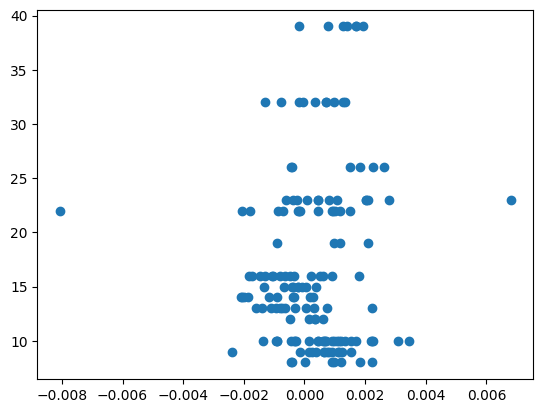

In [114]:
plt.scatter(df.rand_cpe_slopes,df.subj_bdi)

In [115]:
roi_test = []

for roi in plot_full_hfa_data.roi.unique().tolist():
    
    df = plot_full_hfa_data[plot_full_hfa_data.roi==roi]
    r,p_r = pearsonr(df.subj_bdi,df.rand_cpe_slopes)
    
    high_bdi_beta = df.rand_cpe_slopes[df.BDI=='high']
    low_bdi_beta = df.rand_cpe_slopes[df.BDI=='low']
    t,p_t = ttest_ind(low_bdi_beta,high_bdi_beta)
    
    roi_test.append(pd.DataFrame({'roi':roi,'Rval':[r],'P_rcorr':[p_r],'Tval':[t],'P_ttest':[p_t]}))

roi_test = pd.concat(roi_test)
roi_test
    
    

,roi,Rval,P_rcorr,Tval,P_ttest
0,acc,-0.087905,0.257185,-0.047944,0.961819
0,dmpfc,0.012331,0.866619,-1.542914,0.124551
0,amy,0.213314,0.051385,-0.968867,0.335461
0,sts,-0.150354,0.125784,2.013228,0.046699
0,ains,-0.017418,0.904440,-1.215657,0.230061
0,vlpfc,-0.093553,0.434422,1.429463,0.157319
0,hpc,-0.056004,0.612862,1.019686,0.310877
0,ofc,0.090280,0.263925,-1.711457,0.089023
0,pins,0.048529,0.748762,-0.877410,0.385030
0,dlpfc,-0.172900,0.105167,1.139098,0.257789


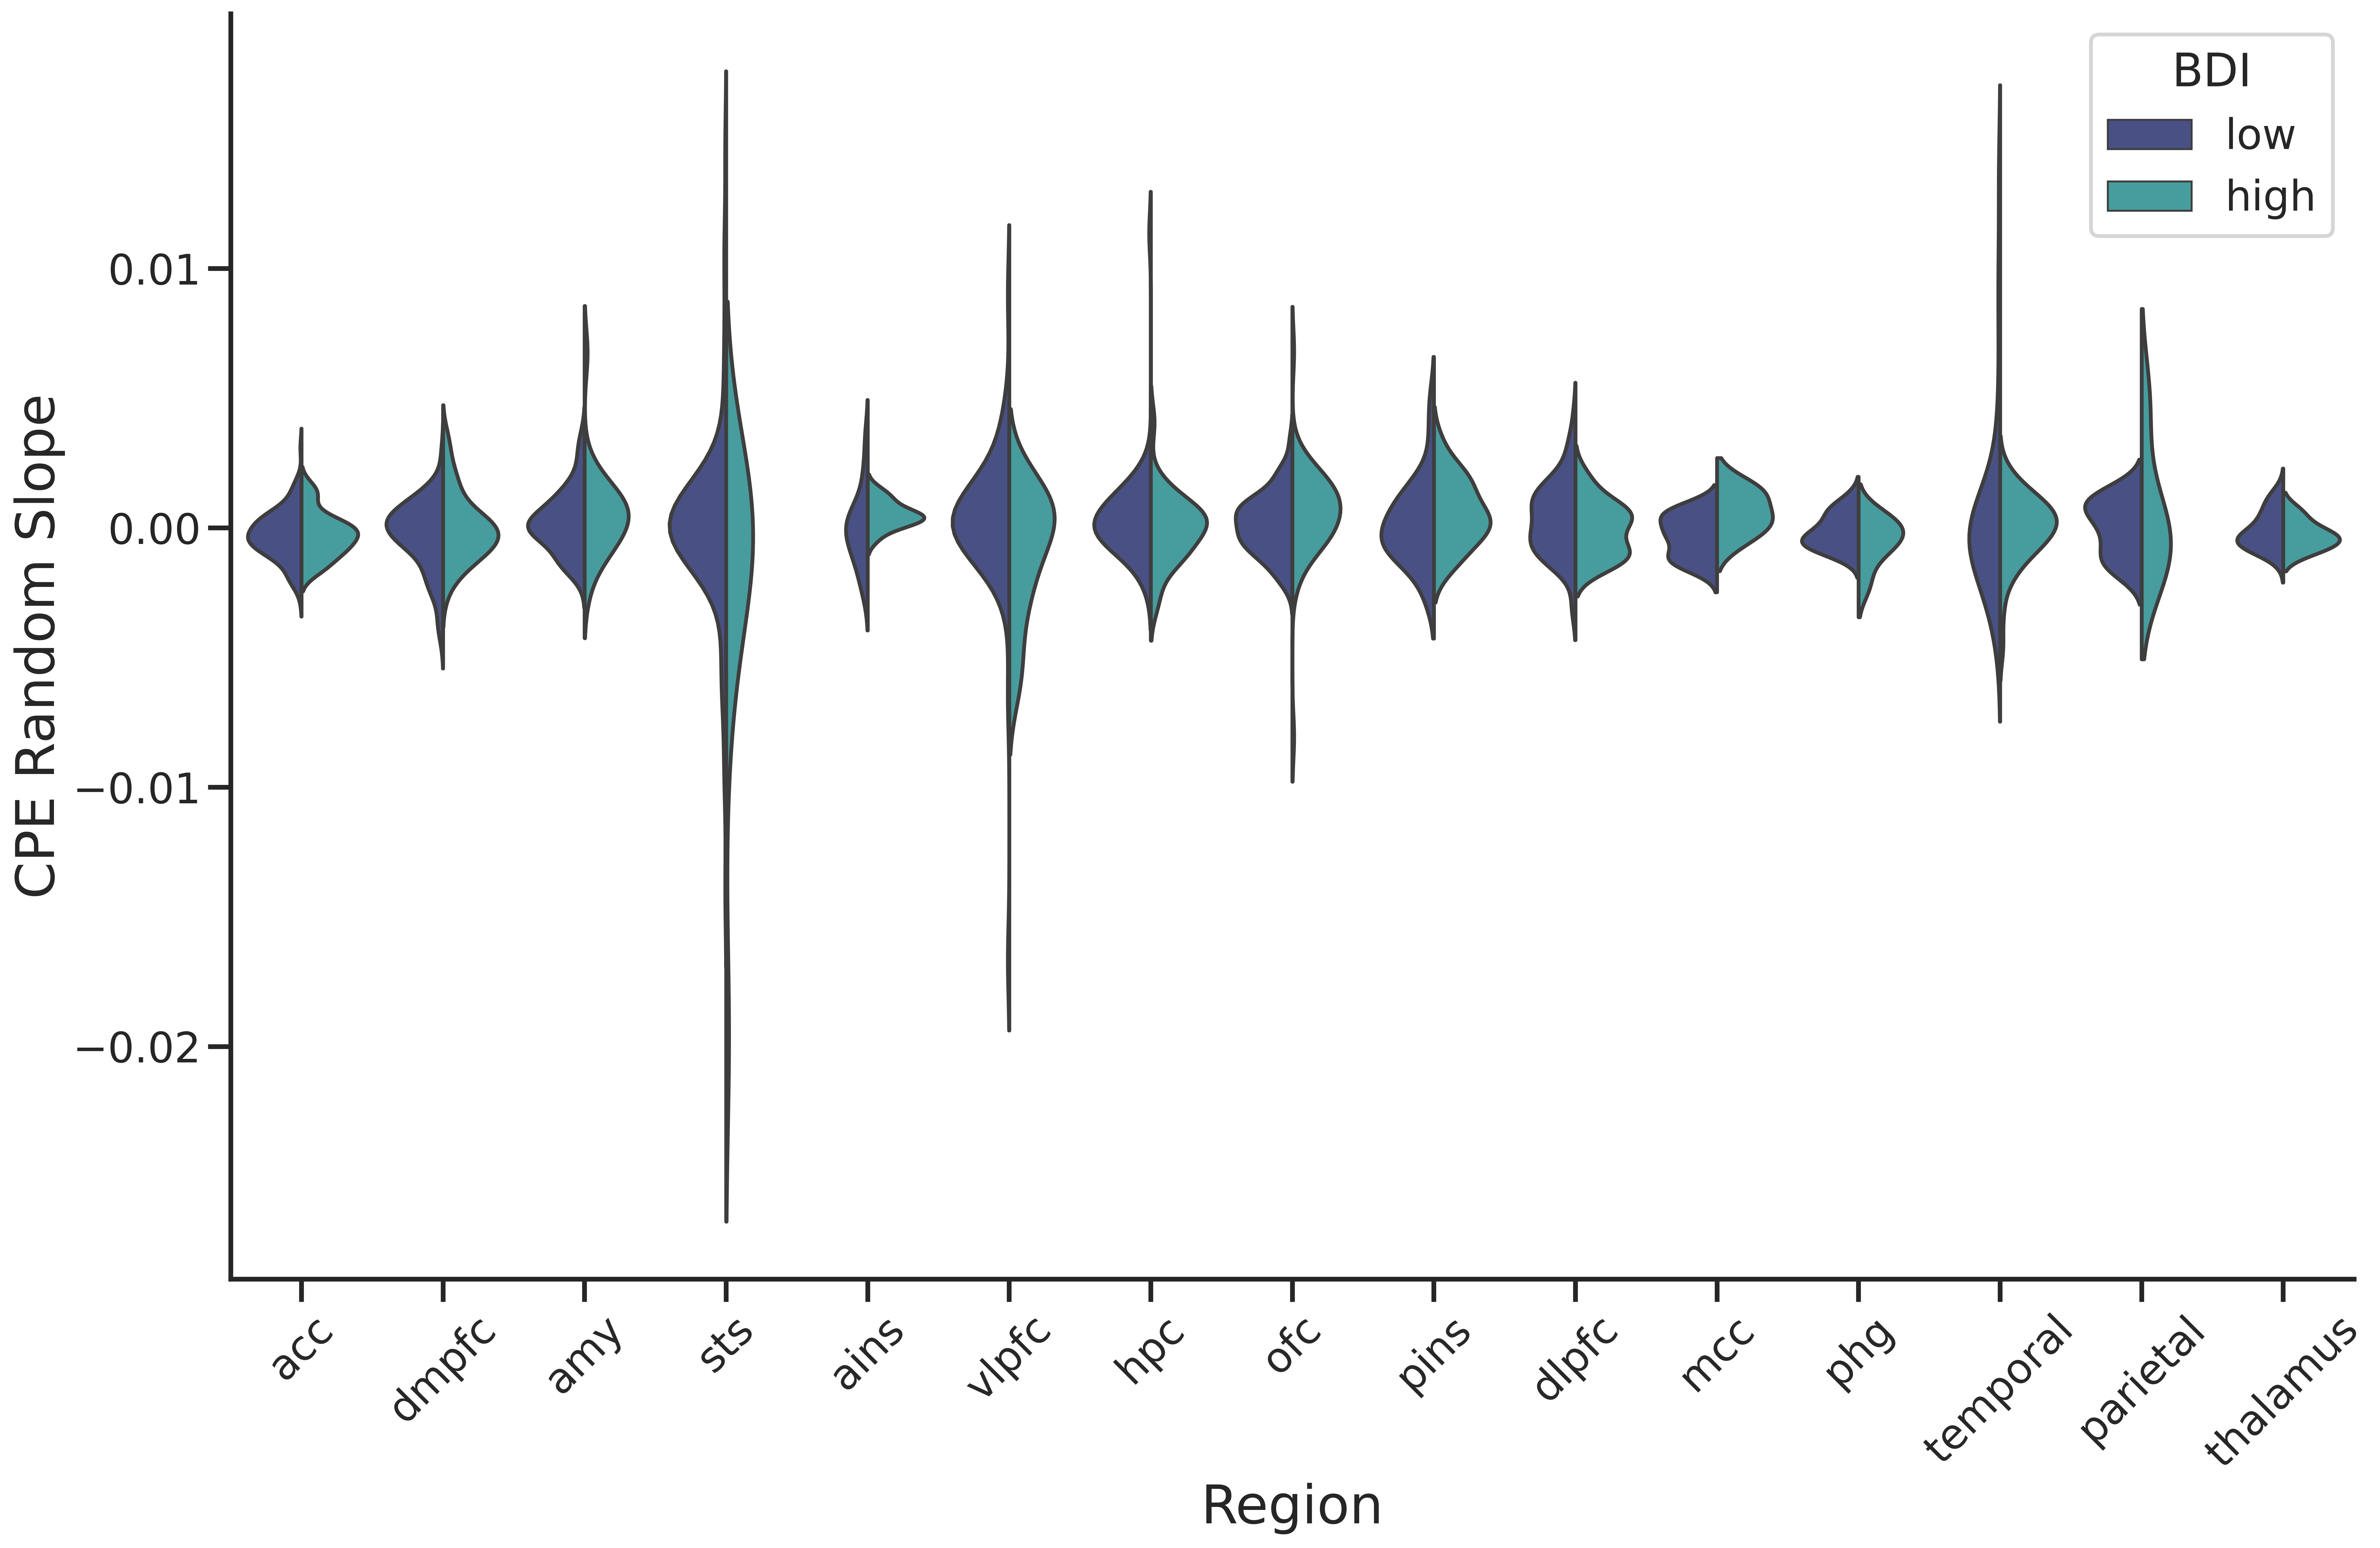

In [116]:
sns.set_theme(style='ticks') 
sns.set_context("poster")

fig,ax = plt.subplots(figsize=(20, 12),dpi=500)

sns.violinplot(data = plot_full_hfa_data,
              x = plot_full_hfa_data.roi, y = full_hfa_model_results.rand_cpe_slopes,
              hue=plot_full_hfa_data.BDI,split=True, density_norm='area', inner=None,
              orient='v', linewidth = 2, fill=True, palette='mako')

ax.tick_params(axis='x', rotation=45)
plt.ylabel('CPE Random Slope',fontsize=28,x=0.1)
plt.xlabel('Region',fontsize=28,y=-0.03)
sns.despine()

In [53]:
roi_means_df = full_hfa_model_results.groupby(['roi']).agg('mean')

In [54]:
roi_means_df

,rand_intercepts,rand_cpe_slopes
roi,,
acc,-0.000849,-3.845263e-04
ains,0.047968,-1.021164e-04
amy,-0.008941,8.066818e-05
caudate,-0.001610,-7.766108e-04
dlpfc,0.009120,1.055689e-04
dmpfc,0.007249,-3.940470e-04
hpc,-0.082093,-2.737508e-04
mcc,-0.016887,-3.932431e-04
motor,0.074159,1.076834e-03


### Check regressor collinearity
- gamble EV is the best offer predictor 
- CPE/RPE shouldn't be split by +/-
- CF is too corr with CPE 
- profit is too correlated
- total profit across the task is fine 
- for behav CPE+RPE ruins result
- choice_t, profit_t, cpe_t, type_t1, gamEV_t1 (choice, type, EV either t or t1 both sig)
- can't use choice_t, type_t, no gamEV
- final behav model : logRT_t1 ~ choice_t + total_profit_t + cpe_t + type_t1 + gamEV_t1


In [56]:
regressor_picks = ['epoch','TrialType', 'SafeBet', 'LowBet', 'HighBet', 'GambleChoice', 'Outcome',
                   'Profit', 'TotalProfit','GambleEV', 'CR', 'choiceEV', 'RPE', 'totalCPE', 
                   'totalRegret','decisionRegret','totalRelief','decisionRelief','totalCF','decisionCF',
                   'pRPE','nRPE']
#'C(epoch)','C(TrialType)', 'SafeBet', 'LowBet', 'HighBet', 'C(GambleChoice)', 'C(Outcome)',

In [58]:
vif_info = []

for reg in regressor_picks:
    reg_data = regression_master_df[reg]
    print(reg_data.unique().tolist())
    vif_df = pd.DataFrame({'decisionCPE':regression_master_df.decisionCPE,
                       'test_reg':reg_data})
    vif_df.astype(float)
    vif_data = pd.DataFrame() 
    vif_data["feature"] = vif_df.columns 
    # calculating VIF for each feature 
    vif_data["VIF"] = [variance_inflation_factor(vif_df.values, i) #, missing='drop') 
                              for i in range(len(vif_df.columns))] 
    vif_score = vif_data[vif_data.feature == 'test_reg'].VIF.item()
    cpe_vif_score = vif_data[vif_data.feature == 'decisionCPE'].VIF.item()
    
    vif_info.append(pd.DataFrame({'reg':[reg],'reg_VIF':[vif_score],'cpe_VIF':[cpe_vif_score]}))

vif_info = pd.concat(vif_info)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 18, 149, 150, 151]
[2, 1, 3]
[0.0058074790413904015, -0.8595068981257805, 1.1595599819309519, 1.447998107653342, -1.7248212752929517, 0.8711218562085614, 0.5826837304861711, 1.7364362333757322, -1.4363831495705612, -0.5710687724033903, -1.147945023848171, 1.7320508075688772, 4.273250414185698e-18, -1.7320508075688772, 1.4433756729740643, 0.8660254037844386, 1.154700

[-1.9868191248984373, -2.603195934965664, -1.5131822076888835, -0.7086482661274499, -1.6753866313907853, -2.3890860956791533, -1.844079232040763, -2.2333698489253284, -1.2601433067139174, -1.6494339235984816, -1.9738427710022854, -1.3834186687273624, -0.7410891508678308, -0.09227145606022326, -0.416680303464027, 0.6214280082281448, 0.49166446926662377, 0.36190093030510156, -0.027389686579462728, 0.7901206088781226, 1.2572693491396005, 1.0626240406973178, 0.6733334238127535, 0.5435698848512324, 0.15427926796666813, 0.024515729005145922, 0.2840428069281892, 0.9977422712165572, 0.8030969627742757, 1.19238757965884, 1.4519146575818833, 0.7187506624492862, 0.9133959708915689, 0.5241053540070034, 1.2442929952434487, 1.1145294562819263, 0.9847659173204054, 1.3740565342049698, -0.2479877028140492, -0.44263301125633076, -0.3128694722948097, -0.05334239437176648, 0.2710664530320373, 0.6603570699166016, 0.3359482225127978, 0.1413029140705151, 0.40082999199355834, 0.5305935309550806, 0.20618468355

[-0.7218632339389505, 1.8481382554594006, 0.5019469991078834, 1.175042627283642, 0.9608758365004463, -0.2629343965463878, 0.563137510760225, 3.8674251399866764, 0.027720533802235256, 0.6702209061518231, 0.7926019294565065, 0.807899557369592, 0.9302805806742754, 2.4906386278089885, 1.5727809530238632, 0.3948636037162854, 1.205637883109813, 0.0430181617153207, 0.37956597580319995, 1.2668283947621548, -0.415910675677242, 1.6645667205023758, -0.09466048950244815, 0.9761734644135318, 0.1959944408461749, -0.3394225361118149, -0.1099581174155335, 1.1138521156313004, -0.20174388489404604, -0.17114862906787526, -0.04876760576319184, 1.7257572321547174, 0.8690900690219338, -0.5076964431557546, 0.10420867336766244, 3.45438918633337, 0.7467090457172502, 0.30307783623777296, 3.484984442159541, 2.031709790416426, -0.6544032893197964, -0.18935722001454744, -0.16550870363991935, -0.05819037995409263, -0.4159181255735149, 0.8957502750310334, 2.922874166874426, -0.2609027691384319, 0.7765076931578926, 0

In [59]:
vif_info

,reg,reg_VIF,cpe_VIF
0,epoch,1.000017,1.000017
0,TrialType,1.000029,1.000029
0,SafeBet,1.000072,1.000072
0,LowBet,1.001989,1.001989
0,HighBet,1.003773,1.003773
0,GambleChoice,1.000014,1.000014
0,Outcome,1.070041,1.070041
0,Profit,1.507875,1.507875
0,TotalProfit,1.006883,1.006883
0,GambleEV,1.000163,1.000163


In [60]:
colinear_regs = list(vif_info.reg[vif_info.reg_VIF>2.5])
colinear_regs


['totalCPE', 'decisionRegret', 'totalRelief', 'decisionRelief']

In [61]:
regs_to_test = list(vif_info.reg[~(vif_info.reg_VIF>2.5)])
# vif_info
regs_to_test


['epoch',
 'TrialType',
 'SafeBet',
 'LowBet',
 'HighBet',
 'GambleChoice',
 'Outcome',
 'Profit',
 'TotalProfit',
 'GambleEV',
 'CR',
 'choiceEV',
 'RPE',
 'totalRegret',
 'totalCF',
 'decisionCF',
 'pRPE',
 'nRPE']

In [ ]:
######### should only use either trial type or choice for model

# Model Evaluation
relevant resources - 
- https://jinhyuncheong.com/jekyll/update/2021/03/20/How_to_run_LMER_in_Python.html 
- https://www.statsmodels.org/0.9.0/examples/notebooks/generated/mixed_lm_example.html
- https://duchesnay.github.io/pystatsml/statistics/lmm/lmm.html
- https://cims.nyu.edu/~brenden/courses/labincp/chapters/15/00-mixed-effect.html
- https://www.kaggle.com/code/ojwatson/mixed-models/notebook
- https://disease-progression-modelling.github.io/pages/notebooks/disease_course_mapping/TP1_LMM.html
- https://www.pythonfordatascience.org/mixed-effects-regression-python/
- https://medium.com/@josef.waples/linear-mixed-effect-models-in-python-using-mtcars-064c6c3e5b32
- https://edwardlib.org/tutorials/linear-mixed-effects-models
- https://jbhender.github.io/Stats506/F18/GP/Group16.html
- https://www.cl.uni-heidelberg.de/statnlpgroup/empirical_methods/kreutzer_significance-python.html
- https://github.com/junpenglao/GLMM-in-Python/blob/master/GLMM_in_python.ipynb
- https://stats.stackexchange.com/questions/51186/what-would-be-an-illustrative-picture-for-linear-mixed-models/51187#51187
- https://towardsdatascience.com/generalized-linear-mixed-effects-models-in-r-and-python-with-gpboost-89297622820c
- https://support.minitab.com/en-us/minitab/help-and-how-to/statistical-modeling/anova/how-to/mixed-effects-model/interpret-the-results/key-results/


#paper for methods - Newton-Raphson and EM Algorithms for Linear Mixed-Effects Models for Repeated-Measures Data